(frailty_models)=
# Frailty and Survival Regression Models

:::{post} January, 2023
:tags: frailty models, survival analysis, competing risks
:category: intermediate, reference
:author: Nathaniel Forde
:::

In [293]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
from matplotlib import cm

In [294]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(42)

In [295]:
retention_df = pd.read_csv('../data/time_to_attrition.csv')

dummies = pd.concat([pd.get_dummies(retention_df['gender'], drop_first=True),
pd.get_dummies(retention_df['level'], drop_first=True),
pd.get_dummies(retention_df['field'], drop_first=True), 
], axis=1)

retention_df = pd.concat([retention_df, dummies], axis=1)
retention_df.head()

gender                   field   level  sentiment  intention  left  month  \
0      M       Public/Government    High          3          8     1      1   
1      F                 Finance     Low          8          4     0     12   
2      M  Education and Training  Medium          7          7     1      5   
3      M                 Finance     Low          8          4     0     12   
4      M                 Finance    High          7          6     1      1   

   M  Low  Medium  Finance  Health  Law  Public/Government  Sales/Marketing  
0  1    0       0        0       0    0                  1                0  
1  0    1       0        1       0    0                  0                0  
2  1    0       1        0       0    0                  0                0  
3  1    1       0        1       0    0                  0                0  
4  1    0       0        1       0    0                  0                0

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.9/site-packages/lifelines/plotting.py:964: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


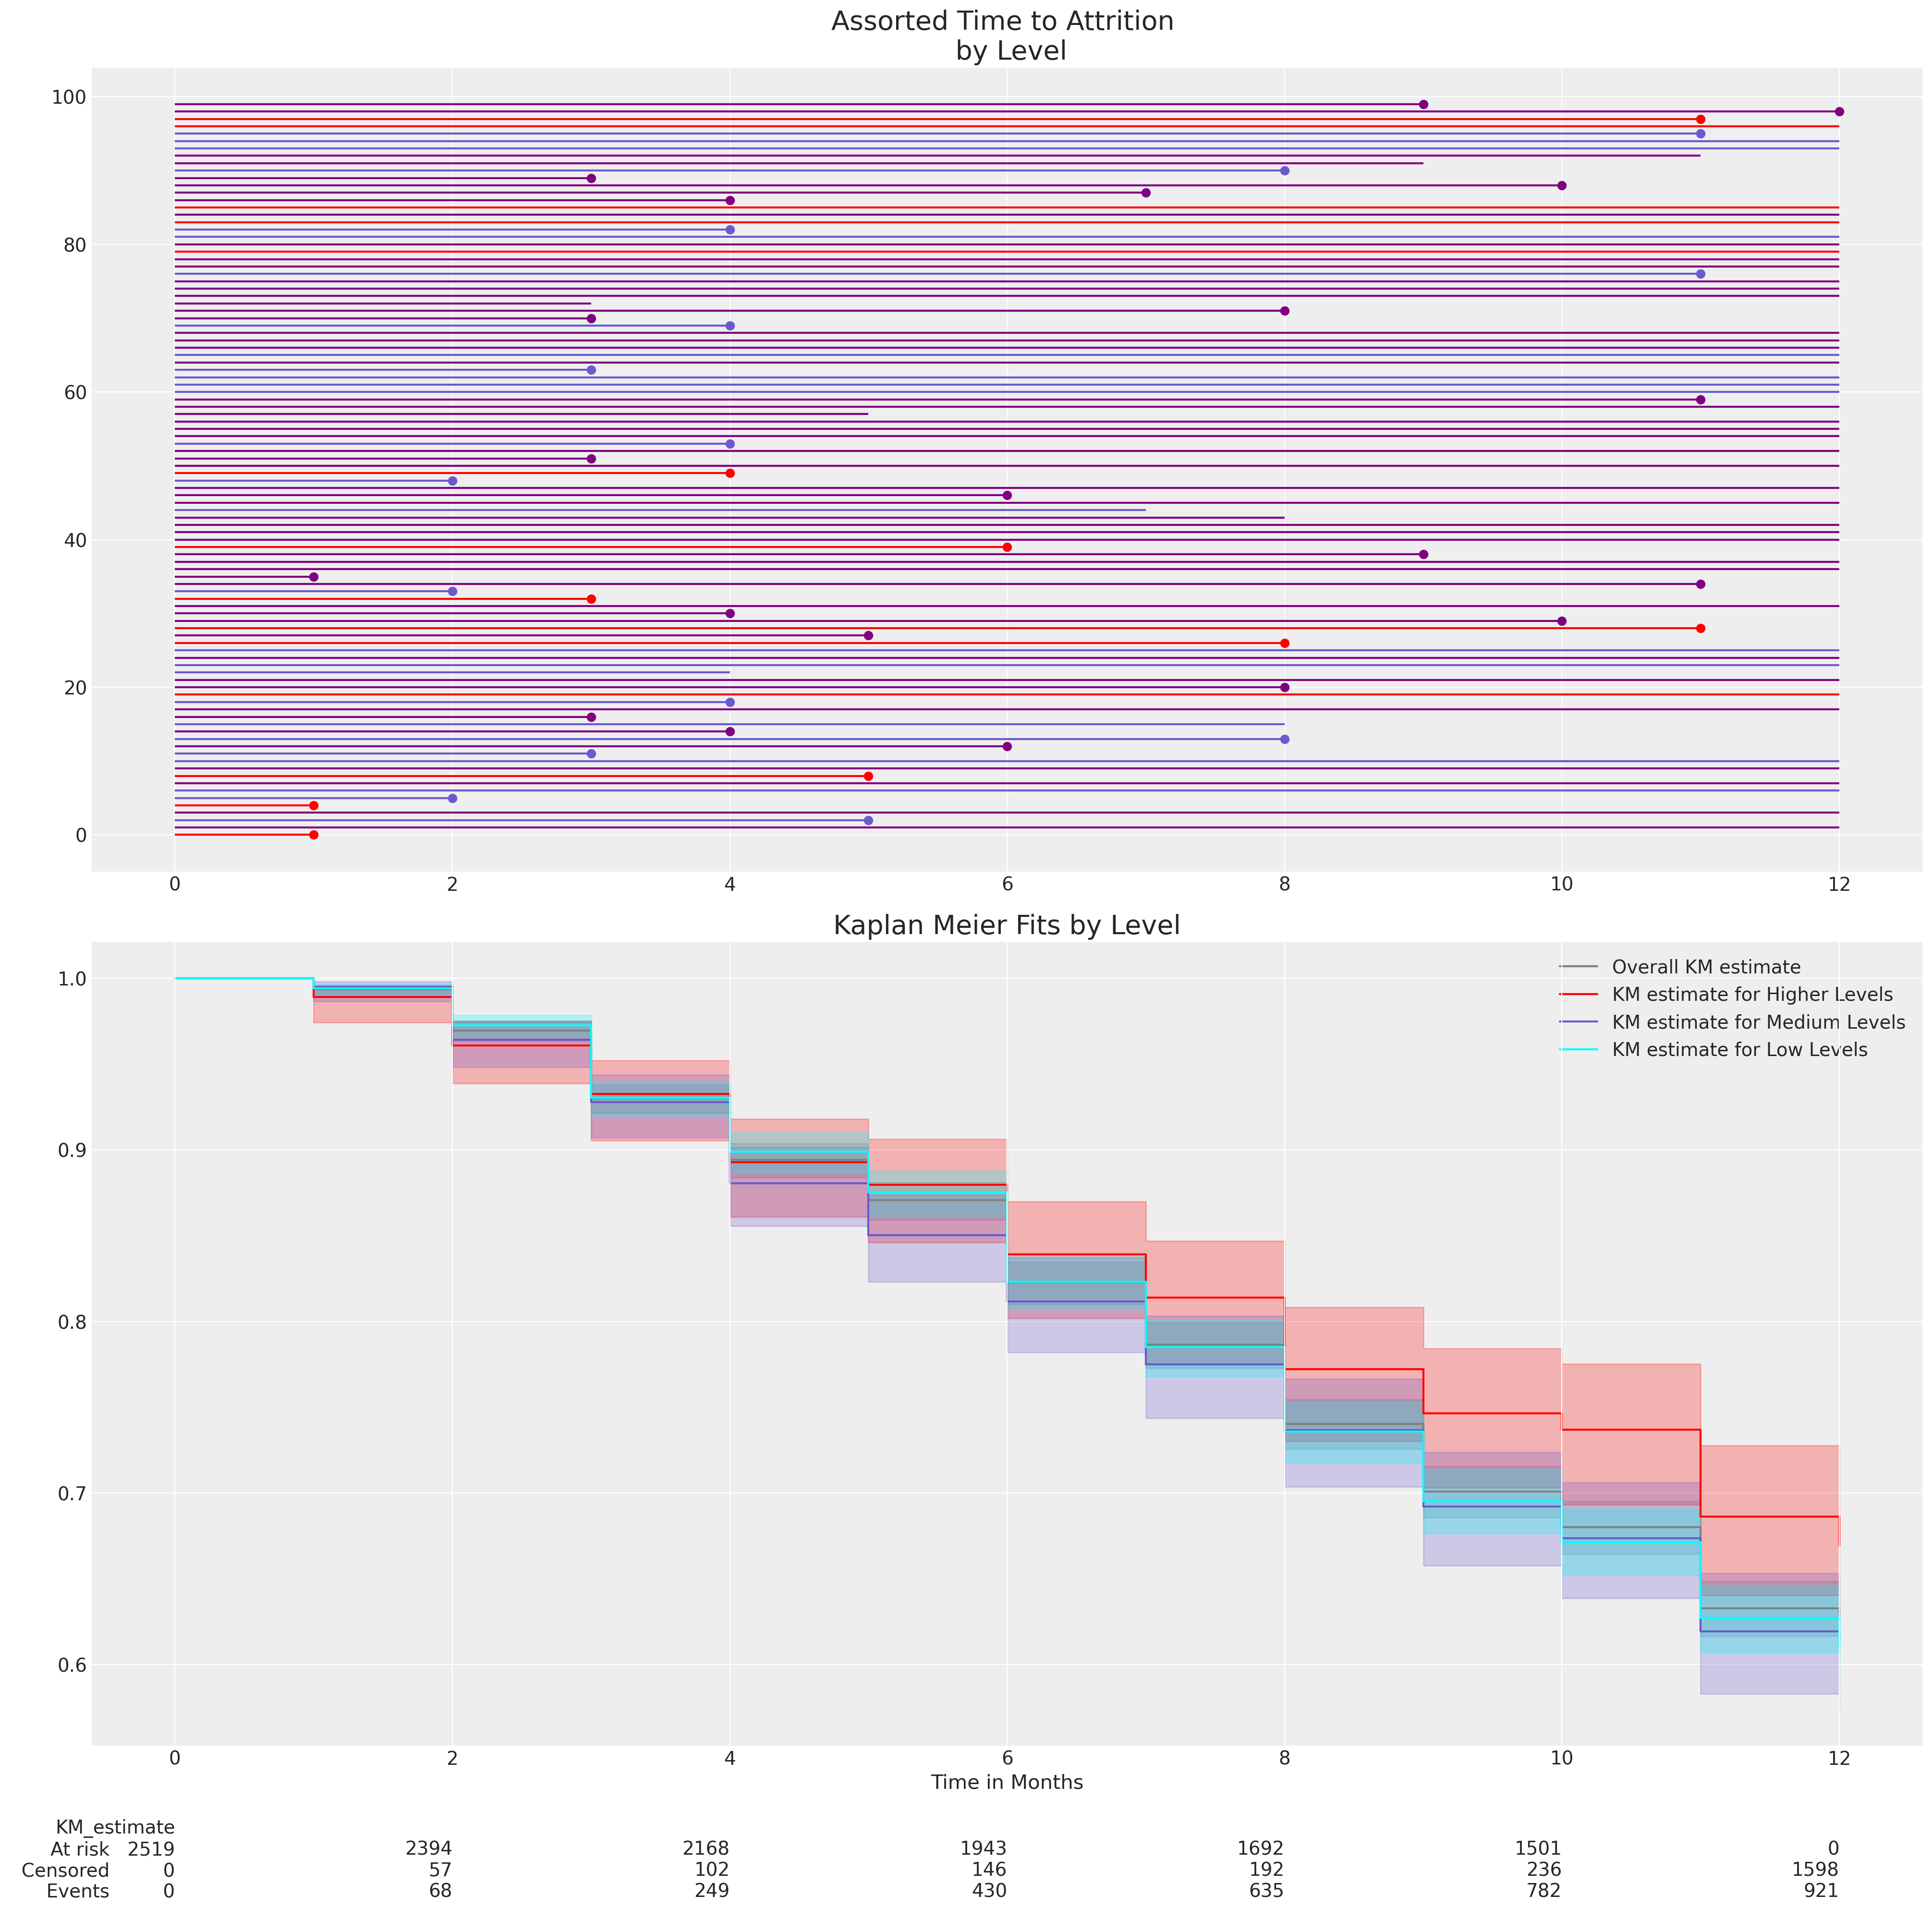

In [18]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()
kmf.fit(retention_df['month'], event_observed=retention_df['left'])
kmf_hi = KaplanMeierFitter()
kmf_hi.fit(retention_df[retention_df['level']=='High']['month'], event_observed=retention_df[retention_df['level']=='High']['left'])
kmf_mid = KaplanMeierFitter()
kmf_mid.fit(retention_df[retention_df['level']=='Medium']['month'], event_observed=retention_df[retention_df['level']=='Medium']['left'])
kmf_low = KaplanMeierFitter()
kmf_low.fit(retention_df[retention_df['level']=='Low']['month'], event_observed=retention_df[retention_df['level']=='Low']['left'])

fig, axs = plt.subplots(2,1, figsize=(20, 20))
axs = axs.flatten()
ax = axs[0]
for i in retention_df.index.unique()[0:100]:
    temp = retention_df[retention_df.index == i]
    event = temp['left'].max() == 1
    level = temp['level'].unique()
    duration = temp['month'].max()
    color = np.where(level == 'High', 'red', np.where(level == 'Medium', 'slateblue', 'purple'))
    ax.hlines(i, 0, duration, color=color)
    if event: 
        ax.scatter(duration, i, color=color)
ax.set_title("Assorted Time to Attrition \n by Level", fontsize=20)

kmf.plot_survival_function(ax=axs[1], label='Overall KM estimate', color='grey')
kmf_hi.plot_survival_function(ax=axs[1], label='KM estimate for Higher Levels', color='red')
kmf_mid.plot_survival_function(ax=axs[1], label='KM estimate for Medium Levels', color='slateblue')
kmf_low.plot_survival_function(ax=axs[1], label='KM estimate for Low Levels', color='cyan', at_risk_counts=True)
axs[1].set_xlabel("Time in Months")
axs[1].set_title("Kaplan Meier Fits by Level", fontsize=20);
    
    

In [20]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(retention_df, duration_col='month', event_col='left', formula="sentiment  + gender + level + field")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 3770 total observations, 2416 right-censored observations>
             duration col = 'month'
                event col = 'left'
      baseline estimation = breslow
   number of observations = 3770
number of events observed = 1354
   partial log-likelihood = -10724.52
         time fit was run = 2023-10-05 18:52:07 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
sentiment                   -0.12       0.89       0.01            -0.14            -0.09                 0.87                 0.91
gender[T.M]                 -0.05       0.96       0.06            -0.16             0.07                 0.85                 1.07
level[T.Low]                 0.15       1.16       0.09            -0.03             0.32                 0.97                 1.38
level[T.Medium]              0.18       1.19       0.10            -0.02             0.38                 0.98                 1.46
field[T.Finance]             0.22       1.25       0.07             0.09             0.35                 1.10                 1.43
field[T.Health]              0.28       1.32       0.13             0.03             0.53                 1.03                 1.70
field[T.Law]                 0.11       1.11       0.15            -0.18             0.39                 0.84                 1.48
field[T.Public/Government]   0.11       1.12       0.09            -0.06             0.29                 0.94                 1.34
field[T.Sales/Marketing]     0.09       1.09       0.10            -0.11             0.29                 0.89                 1.33

                             cmp to     z      p   -log2(p)
covariate                                                  
sentiment                      0.00 -8.41 <0.005      54.49
gender[T.M]                    0.00 -0.77   0.44       1.19
level[T.Low]                   0.00  1.65   0.10       3.32
level[T.Medium]                0.00  1.73   0.08       3.58
field[T.Finance]               0.00  3.34 <0.005      10.24
field[T.Health]                0.00  2.16   0.03       5.02
field[T.Law]                   0.00  0.73   0.47       1.10
field[T.Public/Government]     0.00  1.29   0.20       2.35
field[T.Sales/Marketing]       0.00  0.86   0.39       1.36
---
Concordance = 0.58
Partial AIC = 21467.04
log-likelihood ratio test = 89.18 on 9 df
-log2(p) of ll-ratio test = 48.58

In [552]:
from lifelines import WeibullAFTFitter, LogLogisticAFTFitter
aft = LogLogisticAFTFitter()
aft.fit(retention_df, duration_col='month', event_col='left', formula="sentiment + field + level",)
aft.print_summary()

<lifelines.LogLogisticAFTFitter: fitted with 3770 total observations, 2416 right-censored observations>
             duration col = 'month'
                event col = 'left'
   number of observations = 3770
number of events observed = 1354
           log-likelihood = -5564.23
         time fit was run = 2023-10-07 19:20:07 UTC

---
                                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                          
alpha_ Intercept                    2.28       9.80       0.10             2.09             2.47                 8.09                11.87
       sentiment                    0.08       1.09       0.01             0.06             0.10                 1.06                 1.11
       field[T.Finance]            -0.16       0.86       0.04            -0.24            -0.07                 0.79                 0.93
       field[T.Health]             -0.21       0.81       0.09            -0.38            -0.04                 0.69                 0.96
       field[T.Law]                -0.07       0.93       0.10            -0.26             0.11                 0.77                 1.12
       field[T.Public/Government]  -0.08       0.92       0.06            -0.20             0.03                 0.82                 1.03
       field[T.Sales/Marketing]    -0.07       0.93       0.07            -0.20             0.06                 0.82                 1.06
       level[T.Low]                -0.10       0.91       0.06            -0.21             0.02                 0.81                 1.02
       level[T.Medium]             -0.11       0.89       0.07            -0.24             0.02                 0.78                 1.02
beta_  Intercept                    0.63       1.87       0.02             0.58             0.67                 1.78                 1.96

                                    cmp to     z      p   -log2(p)
param  covariate                                                  
alpha_ Intercept                      0.00 23.28 <0.005     395.88
       sentiment                      0.00  8.37 <0.005      53.91
       field[T.Finance]               0.00 -3.55 <0.005      11.35
       field[T.Health]                0.00 -2.42   0.02       6.00
       field[T.Law]                   0.00 -0.76   0.45       1.16
       field[T.Public/Government]     0.00 -1.43   0.15       2.72
       field[T.Sales/Marketing]       0.00 -1.07   0.28       1.82
       level[T.Low]                   0.00 -1.64   0.10       3.32
       level[T.Medium]                0.00 -1.72   0.08       3.56
beta_  Intercept                      0.00 25.94 <0.005     490.56
---
Concordance = 0.58
AIC = 11148.46
log-likelihood ratio test = 94.69 on 8 df
-log2(p) of ll-ratio test = 54.10

In [553]:
aft_preds = aft.predict_survival_function(retention_df)
aft_preds

0         1         2         3         4         5         6     \
1.0   0.989773  0.993487  0.994112  0.993487  0.993643  0.989898  0.994945   
2.0   0.963603  0.976596  0.978806  0.976596  0.977149  0.964038  0.981767   
3.0   0.925391  0.951335  0.955824  0.951335  0.952456  0.926247  0.961871   
4.0   0.878677  0.919452  0.926654  0.919452  0.921246  0.880000  0.936428   
5.0   0.826736  0.882635  0.892745  0.882635  0.885147  0.828514  0.906583   
6.0   0.772364  0.842463  0.855467  0.842463  0.845684  0.774549  0.873432   
7.0   0.717772  0.800336  0.816058  0.800336  0.804218  0.720290  0.837994   
8.0   0.664568  0.757438  0.775590  0.757438  0.761905  0.667342  0.801176   
9.0   0.613834  0.714720  0.734950  0.714720  0.719683  0.616784  0.763758   
10.0  0.566214  0.672912  0.694841  0.672912  0.678275  0.569274  0.726386   
11.0  0.522032  0.632544  0.655796  0.632544  0.638213  0.525141  0.689573   
12.0  0.481375  0.593976  0.618195  0.593976  0.599864  0.484488  0.653714   

          7         8         9     ...      3760      3761      3762  \
1.0   0.992414  0.994439  0.993496  ...  0.993509  0.996277  0.989383   
2.0   0.972818  0.979969  0.976627  ...  0.976673  0.986523  0.962254   
3.0   0.943715  0.958193  0.951398  ...  0.951492  0.971665  0.922738   
4.0   0.907326  0.930475  0.919552  ...  0.919702  0.952435  0.874589   
5.0   0.865776  0.898138  0.882775  ...  0.882985  0.929539  0.821253   
6.0   0.821003  0.862445  0.842642  ...  0.842911  0.903669  0.765649   
7.0   0.774673  0.824549  0.800551  ...  0.800876  0.875490  0.710050   
8.0   0.728133  0.785458  0.757685  ...  0.758058  0.845624  0.656089   
9.0   0.682418  0.746020  0.714994  ...  0.715408  0.814635  0.604834   
10.0  0.638273  0.706918  0.673208  ...  0.673655  0.783025  0.556906   
11.0  0.596195  0.668681  0.632857  ...  0.633329  0.751223  0.512592   
12.0  0.556487  0.631698  0.594301  ...  0.594791  0.719590  0.471944   

          3763      3764      3765      3766      3767      3768      3769  
1.0   0.992414  0.992808  0.995895  0.992414  0.988031  0.996484  0.994303  
2.0   0.972818  0.974202  0.985154  0.972818  0.957594  0.987267  0.979483  
3.0   0.943715  0.946498  0.968836  0.943715  0.913637  0.973209  0.957202  
4.0   0.907326  0.911740  0.947789  0.907326  0.860672  0.954978  0.928875  
5.0   0.865776  0.871889  0.922837  0.865776  0.802752  0.933220  0.895878  
6.0   0.821003  0.828753  0.894785  0.821003  0.743193  0.908569  0.859516  
7.0   0.774673  0.783900  0.864398  0.774673  0.684462  0.881635  0.820980  
8.0   0.728133  0.738623  0.832380  0.728133  0.628232  0.852996  0.781305  
9.0   0.682418  0.693930  0.799365  0.682418  0.575512  0.823178  0.741355  
10.0  0.638273  0.650566  0.765899  0.638273  0.526810  0.792654  0.701823  
11.0  0.596195  0.609042  0.732444  0.596195  0.482284  0.761833  0.663237  
12.0  0.556487  0.569686  0.699378  0.556487  0.441861  0.731066  0.625986  

[12 rows x 3770 columns]

In [21]:
interval_length = 1
interval_bounds = np.arange(0, retention_df.month.max() + interval_length + 1, interval_length)
n_intervals = interval_bounds.size - 1
intervals = np.arange(n_intervals)
intervals

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [22]:
intervals = np.arange(12)
n_employees = retention_df.shape[0]
n_intervals =len(intervals)
last_period = np.floor((retention_df.month - 0.01) / interval_length).astype(int)
employees = np.arange(n_employees)
quit = np.zeros((n_employees, n_intervals))
quit[employees, last_period] = retention_df['left']

pd.DataFrame(quit)

0    1    2    3    4    5    6    7    8    9    10   11
0     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2     0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4     1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
3765  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3766  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
3767  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
3768  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3769  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

[3770 rows x 12 columns]

In [23]:
exposure = np.greater_equal.outer(retention_df.month.to_numpy(), interval_bounds[:-2]) * interval_length
exposure[employees, last_period] = retention_df.month - interval_bounds[last_period]
pd.DataFrame(exposure)

0   1   2   3   4   5   6   7   8   9   10  11
0      1   1   0   0   0   0   0   0   0   0   0   0
1      1   1   1   1   1   1   1   1   1   1   1   1
2      1   1   1   1   1   1   0   0   0   0   0   0
3      1   1   1   1   1   1   1   1   1   1   1   1
4      1   1   0   0   0   0   0   0   0   0   0   0
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
3765   1   1   1   1   1   1   1   1   1   1   1   1
3766   1   1   1   1   1   1   1   1   1   0   0   0
3767   1   1   1   1   1   1   1   1   1   0   0   0
3768   1   1   1   1   1   1   1   1   1   1   1   1
3769   1   1   1   1   1   1   1   1   1   1   1   1

[3770 rows x 12 columns]

## Fit Basic Model with Fixed Effects

Sampling: [beta, lambda0, obs]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda0, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 40 seconds.


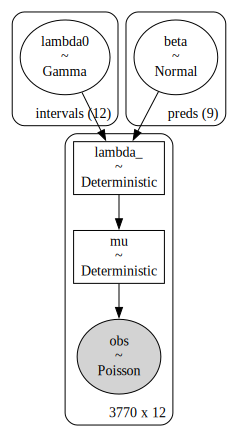

In [25]:
coords = {"intervals": intervals, 
          'preds': ['sentiment', 'Male', 'Low', 'Medium', 
                    'Finance', 'Health', 'Law', 'Public/Government', 'Sales/Marketing'
                    ]}

with pm.Model(coords=coords) as base_model:
    lambda0 = pm.Gamma("lambda0", 0.01, 0.01, dims="intervals")

    beta = pm.Normal("beta", 0, sigma=1, dims ='preds')

    lambda_ = pm.Deterministic("lambda_", pt.outer(pt.exp(beta[0]*retention_df['sentiment'] + 
                                                          beta[1]*retention_df['M'] + 
                                                          beta[2]*retention_df['Low'] + 
                                                          beta[3]*retention_df['Medium'] +
                                                          beta[4]*retention_df['Finance'] +
                                                          beta[5]*retention_df['Health'] +
                                                          beta[6]*retention_df['Law'] +
                                                          beta[7]*retention_df['Public/Government'] +
                                                          beta[8]*retention_df['Sales/Marketing']), lambda0))
    
    mu = pm.Deterministic("mu", exposure*lambda_)

    obs = pm.Poisson("obs", mu, observed=quit)
    base_idata = pm.sample_prior_predictive()
    base_idata.extend(pm.sample())

pm.model_to_graphviz(base_model)

## Fit Model with Shared Frailty terms by Individual

Sampling: [beta, frailty, lambda0, obs]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda0, frailty, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 75 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


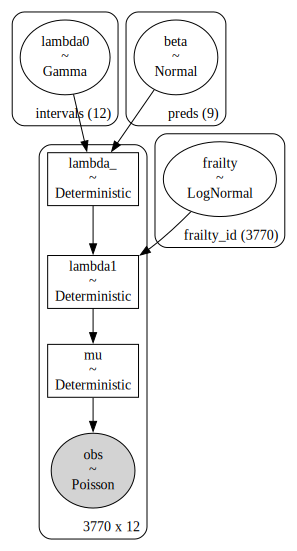

In [52]:
frailty_idx, frailty_labels = pd.factorize(range(len(retention_df)))
coords = {"intervals": intervals, 
          'preds': ['sentiment', 'Male', 'Low', 'Medium', 
                    'Finance', 'Health', 'Law', 'Public/Government', 'Sales/Marketing'], 
          "frailty_id": frailty_labels}

with pm.Model(coords=coords) as frailty_model:
    lambda0 = pm.Gamma("lambda0", 0.01, 0.01, dims="intervals")
    frailty = pm.LogNormal('frailty', 0, 0.25, dims='frailty_id')
    
    
    beta = pm.Normal("beta", 0, sigma=1, dims ='preds')

    lambda_ = pm.Deterministic("lambda_", pt.outer(pt.exp(beta[0]*retention_df['sentiment'] + 
                                                          beta[1]*retention_df['M'] + 
                                                          beta[2]*retention_df['Low'] + 
                                                          beta[3]*retention_df['Medium'] +
                                                          beta[4]*retention_df['Finance'] +
                                                          beta[5]*retention_df['Health'] +
                                                          beta[6]*retention_df['Law'] +
                                                          beta[7]*retention_df['Public/Government'] +
                                                          beta[8]*retention_df['Sales/Marketing']), lambda0))
    lambda1 = pm.Deterministic('lambda1', frailty[frailty_idx, None]*lambda_)
    
    mu = pm.Deterministic("mu", exposure*lambda1)

    obs = pm.Poisson("obs", mu, observed=quit)
    frailty_idata = pm.sample_prior_predictive()
    frailty_idata.extend(pm.sample())

pm.model_to_graphviz(frailty_model)

## Accelerated Failure Time Model

In [558]:
coords = {"intervals": intervals, 
          'preds': ['sentiment','Male', 'Low', 'Medium', 
                    'Finance', 'Health', 'Law', 'Public/Government', 'Sales/Marketing', 'intercept']}

X = retention_df[['sentiment','M', 'Low', 'Medium', 
                    'Finance', 'Health', 'Law', 'Public/Government', 'Sales/Marketing']]
X['intercept'] = 1
y = retention_df['month'].values
cens = retention_df.left.values == 0.0


def logistic_sf(y, μ, s):
    return 1.0 - pm.math.sigmoid((y - μ) / s)

def weibull_lccdf(x, alpha, beta):
    """Log complementary cdf of Weibull distribution."""
    return -((x / beta) ** alpha)

def make_aft(y, weibull=True):
    with pm.Model(coords=coords) as aft_model:
        X_data = pm.MutableData('X_data_obs', X)
        beta = pm.Normal("beta", 0.0, 1, dims='preds')

        if weibull:
            #s = pm.Gamma("s", alpha=1, beta=0.001, testval=0.25)
            s = pm.HalfNormal('s', 5.)
            reg = pm.Deterministic('reg', pt.exp(-(pm.math.dot(beta, X_data.T)) / s))
            y_obs = pm.Weibull("y_obs", beta=reg[~cens], alpha=s, observed=y[~cens])
            y_cens = pm.Potential("y_cens", weibull_lccdf(y[cens], alpha=s, beta=reg[cens]))
        else: 
            s = pm.HalfNormal('s', 5.)
            reg = pm.Deterministic('reg', pm.math.dot(X_data, beta))
            y_obs = pm.Logistic("y_obs", reg[~cens], s, observed=y[~cens])
            y_cens = pm.Potential("y_cens", logistic_sf(y[cens], reg[cens], s))

        idata = pm.sample(target_accept=0.95)
        idata.extend(pm.sample_posterior_predictive(idata))
    return idata, aft_model


weibull_idata, weibull_aft = make_aft(y)
loglogistic_idata, loglogistic_aft = make_aft(np.log(y), weibull=False)

/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_31033/4094634621.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['intercept'] = 1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 78 seconds.
/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_31033/4094634621.py:37: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata.extend(pm.sample_posterior_predictive(idata))
Sampling: [y_obs]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 54 seconds.
/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_31033/4094634621.py:37: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata.extend(pm.sample_posterior_predictive(idata))
Sampling: [y_obs]


In [559]:
individual_accelators = az.summary(weibull_idata, var_names=['reg'])['mean']
expected_shape_param = az.summary(weibull_idata, var_names=['s'])['mean'][0]
weibull_predicted_surv = pd.DataFrame([np.exp(-(np.arange(1, 13, 1) / individual_accelators.iloc[i])**expected_shape_param) 
                                       for i in range(len(individual_accelators))]).T

weibull_predicted_surv

0         1         2         3         4         5         6     \
0   0.987507  0.991046  0.991988  0.991536  0.991513  0.987681  0.992924   
1   0.961523  0.972319  0.975207  0.973822  0.973749  0.962051  0.978081   
2   0.926487  0.946838  0.952318  0.949688  0.949551  0.927478  0.957788   
3   0.884743  0.916117  0.924636  0.920544  0.920331  0.886262  0.933168   
4   0.838073  0.881278  0.893124  0.887428  0.887132  0.840149  0.905036   
5   0.787963  0.843251  0.858577  0.851199  0.850815  0.790598  0.874061   
6   0.735693  0.802841  0.821686  0.812602  0.812130  0.738863  0.840822   
7   0.682365  0.760763  0.783061  0.772296  0.771738  0.686028  0.805833   
8   0.628928  0.717649  0.743250  0.730871  0.730230  0.633027  0.769556   
9   0.576187  0.674060  0.702743  0.688849  0.688132  0.580654  0.732411   
10  0.524808  0.630490  0.661976  0.646697  0.645909  0.529569  0.694773   
11  0.475332  0.587370  0.621336  0.604822  0.603972  0.480310  0.656981   

        7         8         9     ...      3760      3761      3762      3763  \
0   0.990417  0.992388  0.991627  ...  0.991667  0.994163  0.986853  0.990417   
1   0.970394  0.976434  0.974098  ...  0.974221  0.981897  0.959539  0.970394   
2   0.943194  0.954653  0.950213  ...  0.950447  0.965073  0.922771  0.943194   
3   0.910469  0.928274  0.921361  ...  0.921724  0.944577  0.879058  0.910469   
4   0.873451  0.898198  0.888564  ...  0.889069  0.921041  0.830317  0.873451   
5   0.833163  0.865164  0.852669  ...  0.853323  0.894977  0.778142  0.833163   
6   0.790493  0.829814  0.814409  ...  0.815214  0.866827  0.723903  0.790493   
7   0.746221  0.792717  0.774436  ...  0.775389  0.836982  0.668776  0.746221   
8   0.701038  0.754386  0.733329  ...  0.734424  0.805798  0.613763  0.701038   
9   0.655551  0.715278  0.691605  ...  0.692833  0.773598  0.559707  0.655551   
10  0.610293  0.675805  0.649723  ...  0.651072  0.740677  0.507298  0.610293   
11  0.565719  0.636333  0.608088  ...  0.609545  0.707304  0.457085  0.565719   

        3764      3765      3766      3767      3768      3769  
0   0.991164  0.993931  0.990417  0.986107  0.994760  0.992408  
1   0.972681  0.981180  0.970394  0.957274  0.983738  0.976495  
2   0.947525  0.963702  0.943194  0.918538  0.968597  0.954769  
3   0.917183  0.942426  0.910469  0.872600  0.950116  0.928455  
4   0.882758  0.918018  0.873451  0.821531  0.928842  0.898449  
5   0.845161  0.891016  0.833163  0.767055  0.905218  0.865491  
6   0.805185  0.861888  0.790493  0.710646  0.879623  0.830218  
7   0.763530  0.831049  0.746221  0.653560  0.852395  0.793198  
8   0.720816  0.798873  0.701038  0.596861  0.823838  0.754941  
9   0.677598  0.765700  0.655551  0.541431  0.794231  0.715904  
10  0.634362  0.731841  0.610293  0.487980  0.763830  0.676496  
11  0.591534  0.697579  0.565719  0.437065  0.732871  0.637085  

[12 rows x 3770 columns]

In [580]:
individual_accelators = az.summary(loglogistic_idata, var_names=['reg'])['mean']
expected_shape_param = az.summary(loglogistic_idata, var_names=['s'])['mean'][0]
loglogistic_predicted_surv = pd.DataFrame([1 / (1 + np.exp(((np.log(np.arange(1, 13, 1)) - individual_accelators.iloc[i]) / expected_shape_param)
                                                     ) 
                                                )
                                       for i in range(len(individual_accelators)) ]).T

loglogistic_predicted_surv



0         1         2         3         4         5         6     \
0   0.987084  0.993823  0.994969  0.993823  0.993740  0.986168  0.995984   
1   0.941705  0.971435  0.976635  0.971435  0.971059  0.937770  0.981281   
2   0.866813  0.931977  0.943945  0.931977  0.931119  0.858582  0.954791   
3   0.773475  0.877872  0.898322  0.877872  0.876423  0.761066  0.917221   
4   0.674304  0.813378  0.842691  0.813378  0.811328  0.658858  0.870439   
5   0.579062  0.743324  0.780674  0.743324  0.740749  0.562033  0.816985   
6   0.493324  0.672098  0.715850  0.672098  0.669127  0.475966  0.759589   
7   0.419189  0.603075  0.651257  0.603075  0.599850  0.402368  0.700783   
8   0.356591  0.538475  0.589157  0.538475  0.535130  0.340808  0.642663   
9   0.304402  0.479504  0.531022  0.479504  0.476148  0.289887  0.586789   
10  0.261126  0.426602  0.477652  0.426602  0.423314  0.247940  0.534198   
11  0.225270  0.379700  0.429340  0.379700  0.376537  0.213371  0.485482   

        7         8         9     ...      3760      3761      3762      3763  \
0   0.992265  0.994727  0.993905  ...  0.993641  0.997443  0.986912  0.992265   
1   0.964433  0.975536  0.971805  ...  0.970614  0.988017  0.940962  0.964433   
2   0.916139  0.941401  0.932825  ...  0.930106  0.970776  0.865252  0.916139   
3   0.851445  0.893939  0.879307  ...  0.874713  0.945735  0.771109  0.851445   
4   0.776547  0.836348  0.815412  ...  0.808913  0.913549  0.671343  0.776547   
5   0.697804  0.772505  0.745883  ...  0.737724  0.875334  0.575780  0.697804   
6   0.620397  0.706176  0.675056  ...  0.665643  0.832485  0.489962  0.620397   
7   0.547812  0.640489  0.606290  ...  0.596077  0.786498  0.415918  0.547812   
8   0.481945  0.577714  0.541817  ...  0.531224  0.738822  0.353511  0.481945   
9   0.423484  0.519281  0.482863  ...  0.472234  0.690748  0.301561  0.423484   
10  0.372341  0.465919  0.429896  ...  0.419488  0.643347  0.258539  0.372341   
11  0.327992  0.417844  0.382874  ...  0.372859  0.597444  0.222931  0.327992   

        3764      3765      3766      3767      3768      3769  
0   0.991583  0.996766  0.992265  0.984856  0.997320  0.994797  
1   0.961392  0.984884  0.964433  0.932185  0.987447  0.975855  
2   0.909356  0.963303  0.916139  0.847048  0.969410  0.942139  
3   0.840342  0.932306  0.851445  0.743951  0.943267  0.895208  
4   0.761415  0.893055  0.776547  0.637905  0.909757  0.838181  
5   0.679540  0.847295  0.697804  0.539291  0.870105  0.774861  
6   0.600136  0.797043  0.620397  0.453103  0.825815  0.708960  
7   0.526633  0.744315  0.547812  0.380474  0.778485  0.643580  
8   0.460718  0.690921  0.481945  0.320467  0.729635  0.580993  
9   0.402830  0.638347  0.423484  0.271335  0.680601  0.522639  
10  0.352655  0.587707  0.372341  0.231198  0.632472  0.469268  
11  0.309495  0.539766  0.327992  0.198348  0.586070  0.421120  

[12 rows x 3770 columns]

In [566]:
az.summary(loglogistic_idata, var_names=['beta', 's'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
beta[sentiment]          0.101  0.011   0.080    0.122      0.000    0.000   
beta[Male]              -0.000  0.048  -0.085    0.090      0.001    0.001   
beta[Low]               -0.095  0.071  -0.224    0.041      0.001    0.001   
beta[Medium]            -0.119  0.081  -0.268    0.039      0.002    0.001   
beta[Finance]           -0.216  0.052  -0.309   -0.114      0.001    0.001   
beta[Health]            -0.355  0.108  -0.561   -0.157      0.002    0.001   
beta[Law]               -0.109  0.118  -0.320    0.116      0.002    0.002   
beta[Public/Government] -0.139  0.070  -0.275   -0.012      0.001    0.001   
beta[Sales/Marketing]   -0.128  0.082  -0.280    0.029      0.001    0.001   
beta[intercept]          1.771  0.118   1.554    1.985      0.003    0.002   
s                        0.446  0.012   0.424    0.468      0.000    0.000   

                         ess_bulk  ess_tail  r_hat  
beta[sentiment]            2582.0    2245.0    1.0  
beta[Male]                 5170.0    3031.0    1.0  
beta[Low]                  2415.0    3137.0    1.0  
beta[Medium]               2524.0    2855.0    1.0  
beta[Finance]              3372.0    2887.0    1.0  
beta[Health]               4317.0    2948.0    1.0  
beta[Law]                  4416.0    3032.0    1.0  
beta[Public/Government]    3867.0    2557.0    1.0  
beta[Sales/Marketing]      3550.0    2782.0    1.0  
beta[intercept]            1579.0    2378.0    1.0  
s                          5379.0    3027.0    1.0

## Extract Fitted Hazard Terms

In [27]:
def cum_hazard(hazard):
    return hazard.cumsum(dim='intervals')


def survival(hazard):
    return np.exp(-cum_hazard(hazard))


def get_mean(trace):
    return trace.mean(("draw", "chain"))

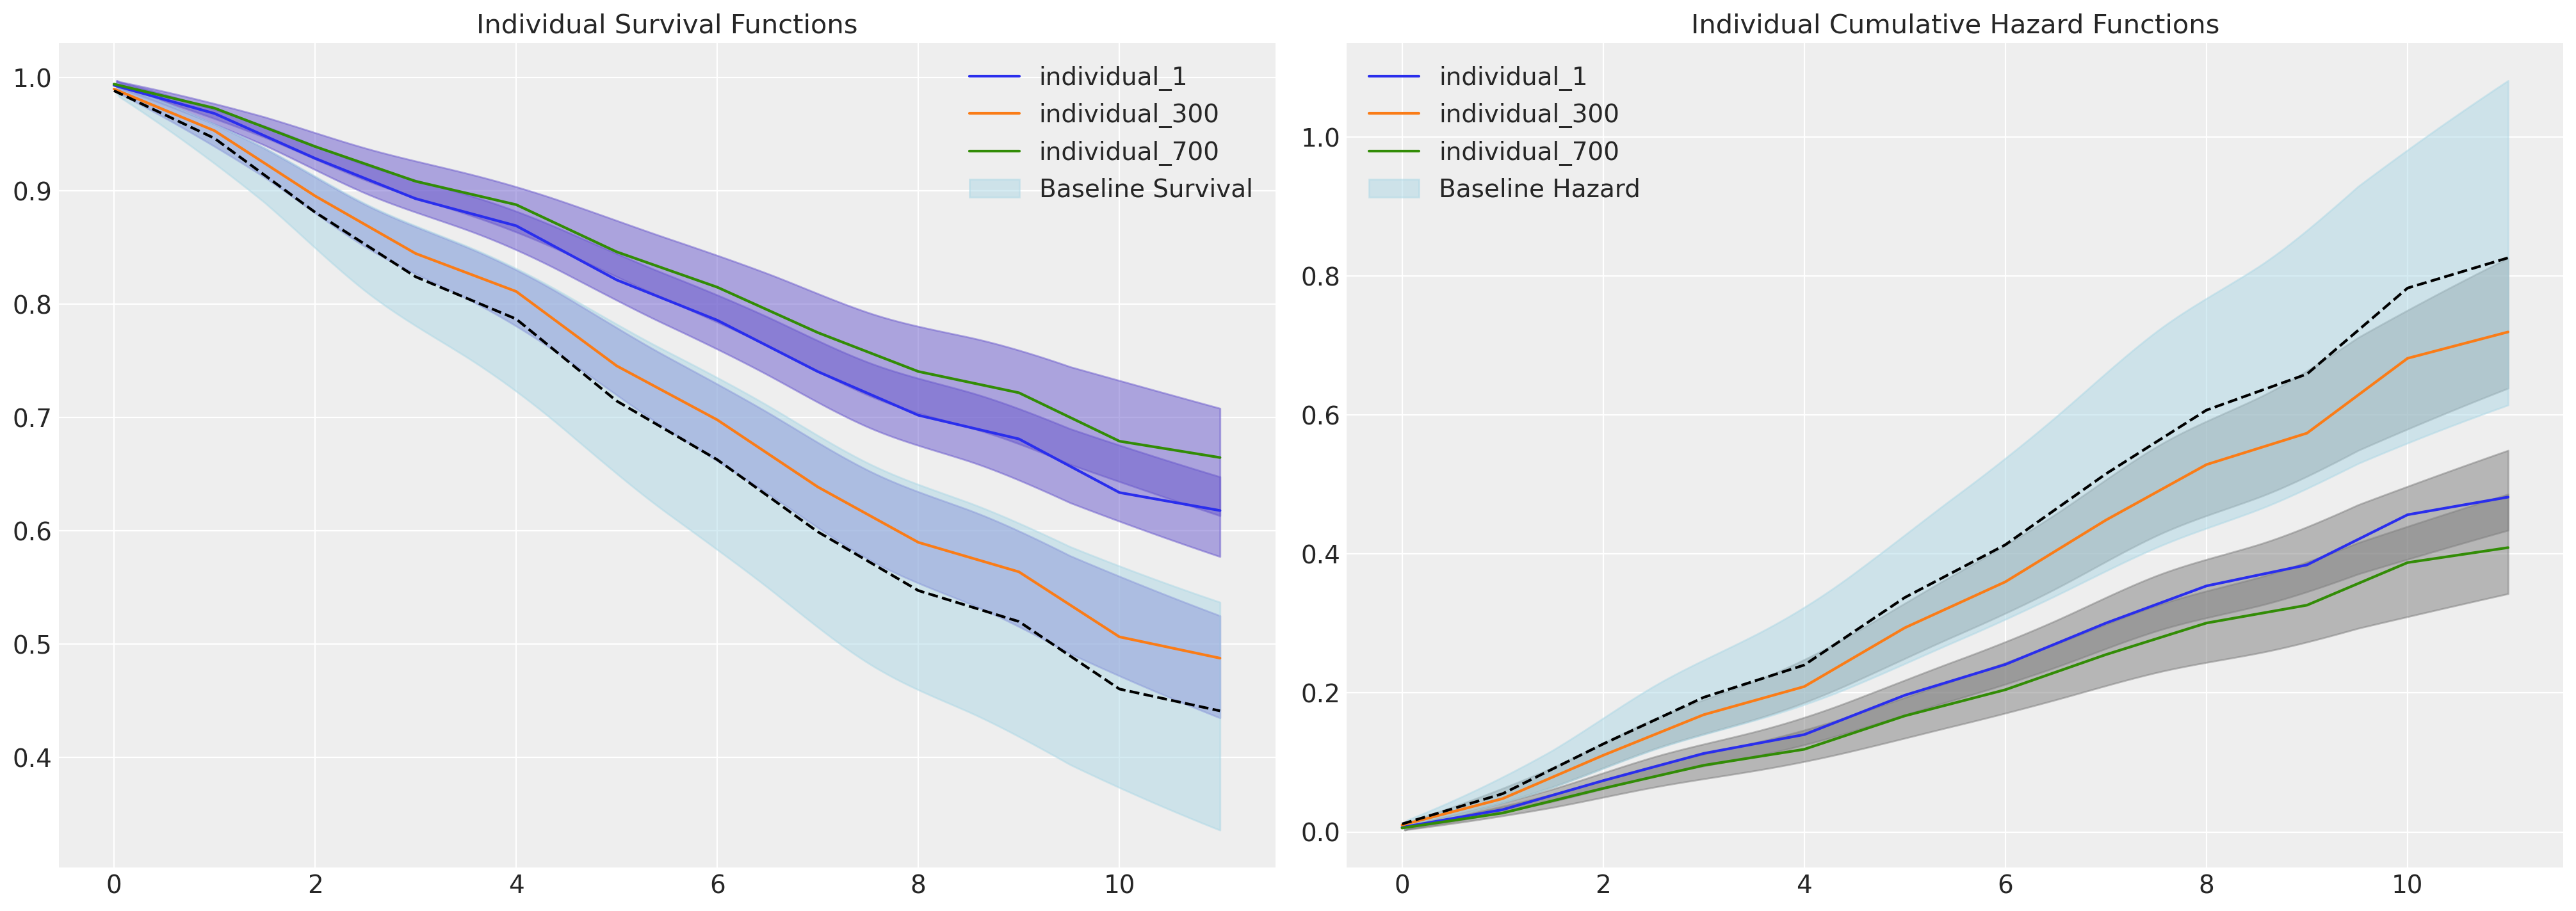

In [35]:
def extract_individual_hazard(i, retention_df):
    hazard_base_m1 = base_idata['posterior']['lambda0']
    beta = base_idata.posterior['beta']
    full_hazard_idata = hazard_base_m1 * np.exp(
                                        beta.sel(preds='sentiment')*retention_df.iloc[i]['sentiment'] + 
                                        beta.sel(preds='Male')*retention_df.iloc[i]['M'] +
                                        beta.sel(preds='Low')*retention_df.iloc[i]['Low'] +  
                                        beta.sel(preds='Medium')*retention_df.iloc[i]['Medium'] +
                                        beta.sel(preds='Finance')*retention_df.iloc[i]['Finance'] +
                                        beta.sel(preds='Health')*retention_df.iloc[i]['Health'] +
                                        beta.sel(preds='Law')*retention_df.iloc[i]['Law'] +
                                        beta.sel(preds='Public/Government')*retention_df.iloc[i]['Public/Government'] +
                                        beta.sel(preds='Sales/Marketing')*retention_df.iloc[i]['Sales/Marketing'] 
                                        )

    cum_haz_idata = cum_hazard(full_hazard_idata)
    survival_idata = survival(full_hazard_idata)
    return full_hazard_idata, cum_haz_idata, survival_idata, hazard_base_m1


def plot_individuals(retention_df, individuals=[1, 300, 700]): 
    fig, axs = plt.subplots(1, 2, figsize=(20, 7))
    axs = axs.flatten()
    for i in individuals:
        haz_idata, cum_haz_idata, survival_idata, base_hazard = extract_individual_hazard(i, retention_df)
        axs[0].plot(get_mean(survival_idata), label=f'individual_{i}')
        az.plot_hdi(range(12),survival_idata, ax=axs[0], fill_kwargs={'color': 'slateblue'})
        axs[1].plot(get_mean(cum_haz_idata), label=f'individual_{i}')
        az.plot_hdi(range(12),cum_haz_idata, ax=axs[1], fill_kwargs={'color': 'grey'})
        axs[0].set_title("Individual Survival Functions", fontsize=15)
        axs[1].set_title("Individual Cumulative Hazard Functions", fontsize=15)
    az.plot_hdi(range(12), survival(base_hazard), color='lightblue', ax=axs[0], fill_kwargs={"label": "Baseline Survival"})
    axs[0].plot(get_mean(survival(base_hazard)), color='black', linestyle='--')
    az.plot_hdi(range(12), cum_hazard(base_hazard), color='lightblue', ax=axs[1], fill_kwargs={"label": "Baseline Hazard"})
    axs[1].plot(get_mean(cum_hazard(base_hazard)), color='black', linestyle='--')
    axs[0].legend()
    axs[1].legend()



plot_individuals(retention_df)



In [36]:
retention_df[retention_df.index.isin([1, 300, 700])]

gender            field level  sentiment  intention  left  month  M  Low  \
1        F          Finance   Low          8          4     0     12  0    1   
300      M          Finance   Low          4          6     0      2  1    1   
700      M  Sales/Marketing   Low          8          3     0     12  1    1   

     Medium  Finance  Health  Law  Public/Government  Sales/Marketing  
1         0        1       0    0                  0                0  
300       0        1       0    0                  0                0  
700       0        0       0    0                  0                1

## Predicting Marginal Effects

In [37]:
test_df = pd.DataFrame(np.zeros((3, 15)), columns=retention_df.columns)
test_df['sentiment'] = [1, 5, 10]
test_df['Medium'] = [1, 1, 1]
test_df['Finance'] = [1, 1, 1]
test_df['M'] = [0, 0, 0]
test_df

gender  field  level  sentiment  intention  left  month  M  Low  Medium  \
0     0.0    0.0    0.0          1        0.0   0.0    0.0  0  0.0       1   
1     0.0    0.0    0.0          5        0.0   0.0    0.0  0  0.0       1   
2     0.0    0.0    0.0         10        0.0   0.0    0.0  0  0.0       1   

   Finance  Health  Law  Public/Government  Sales/Marketing  
0        1     0.0  0.0                0.0              0.0  
1        1     0.0  0.0                0.0              0.0  
2        1     0.0  0.0                0.0              0.0

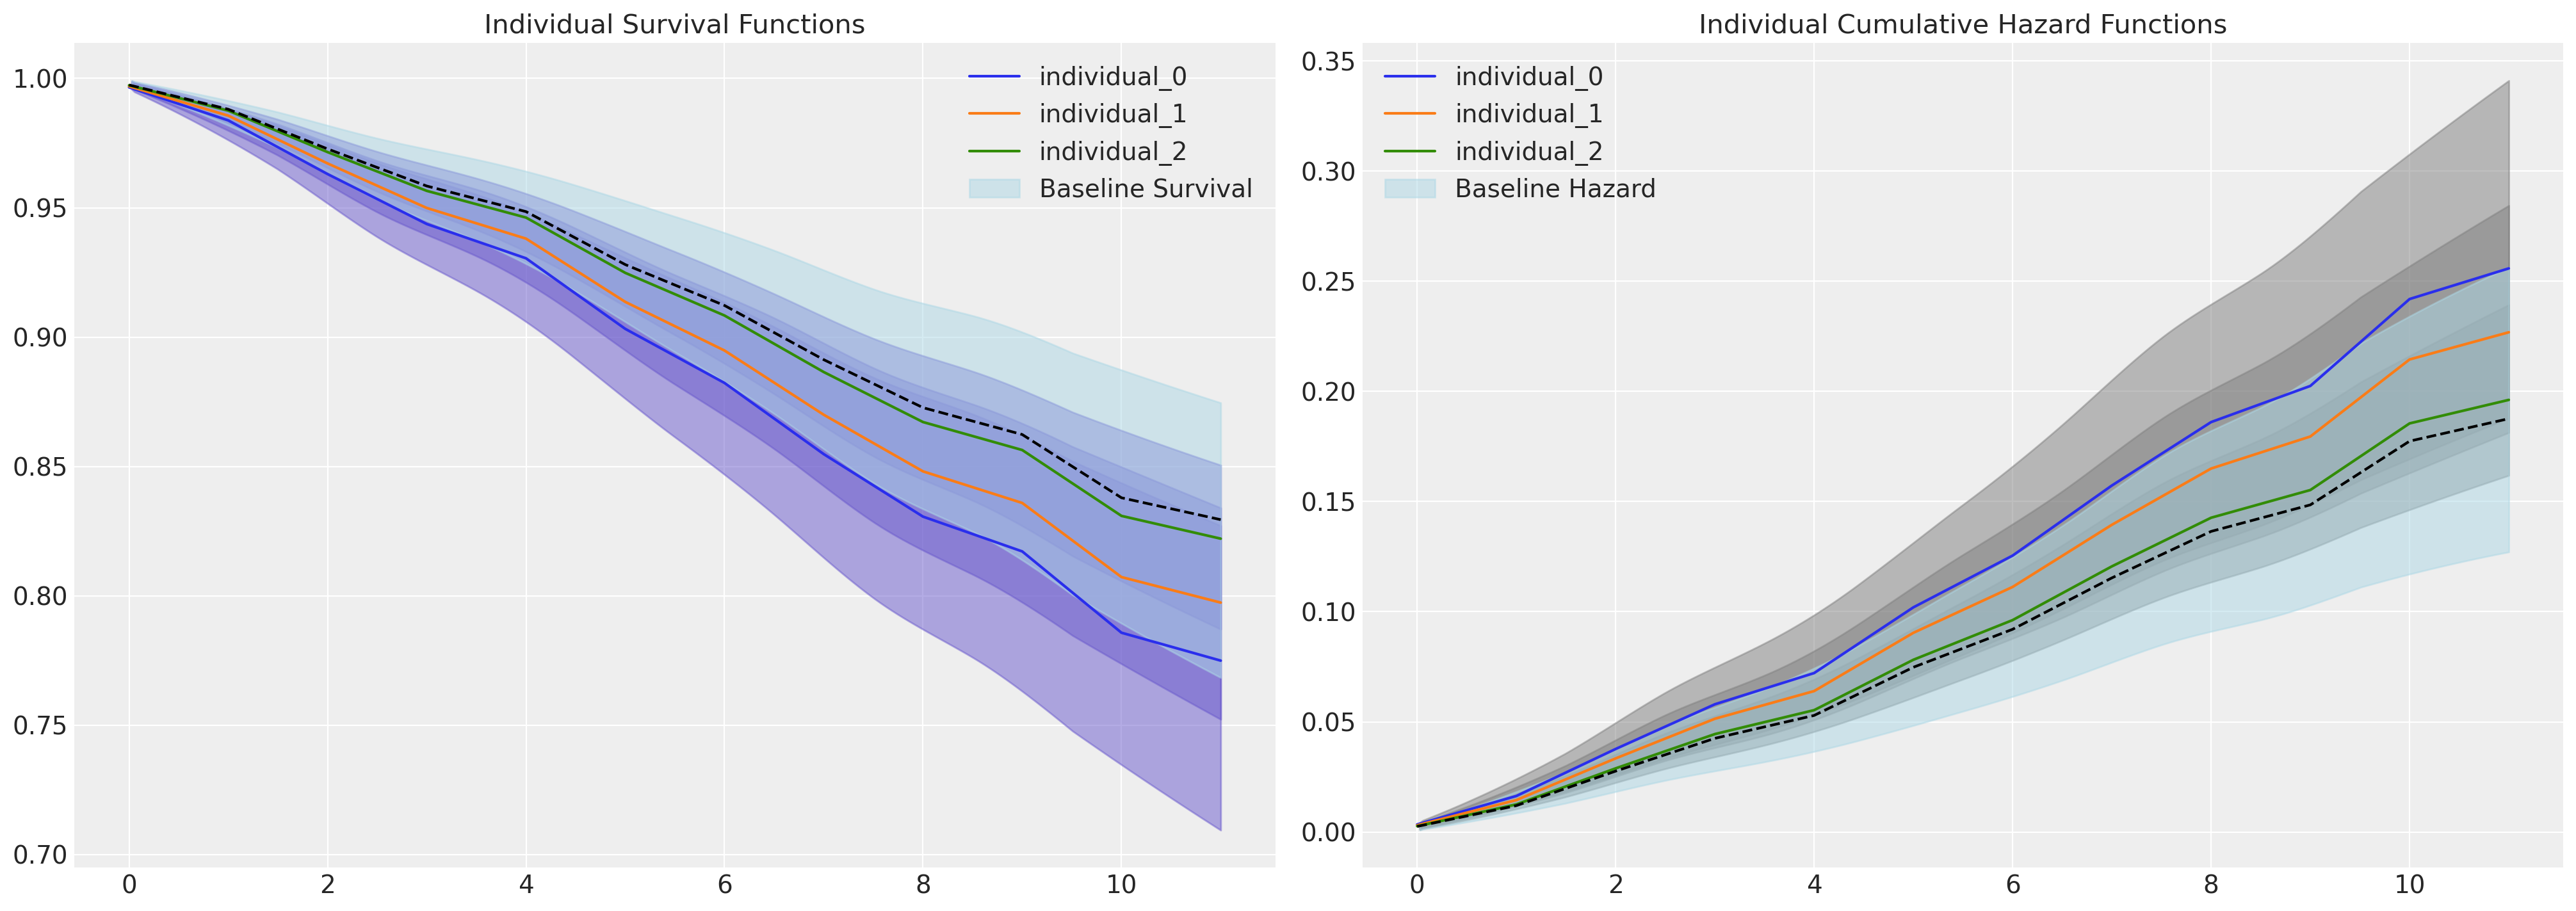

In [643]:
plot_individuals(test_df, [0, 1, 2])

In [38]:
def create_predictions(retention_df):
    cum_haz = {}
    surv = {}
    for i in range(len(retention_df)):
        haz_idata, cum_haz_idata, survival_idata, base_hazard = extract_individual_hazard(i, retention_df)
        cum_haz[i] = get_mean(cum_haz_idata)
        surv[i] = get_mean(survival_idata)
    cum_haz = pd.DataFrame(cum_haz)
    surv = pd.DataFrame(surv)
    return cum_haz, surv

cum_haz_df, surv_df = create_predictions(retention_df)
cum_haz_df.head()

0         1         2         3         4         5         6     \
0  0.008882  0.006762  0.006042  0.006513  0.006354  0.009049  0.005416   
1  0.042198  0.032148  0.028711  0.030954  0.030196  0.043038  0.025735   
2  0.097013  0.073896  0.066008  0.071158  0.069413  0.098970  0.059165   
3  0.148381  0.113027  0.100960  0.108836  0.106168  0.151365  0.090493   
4  0.183984  0.140142  0.125180  0.134948  0.131644  0.187701  0.112202   

       7         8         9     ...      3760      3761      3762      3763  \
0  0.007265  0.005724  0.006552  ...  0.006407  0.004523  0.009480  0.007265   
1  0.034530  0.027192  0.031120  ...  0.030455  0.021495  0.045077  0.034530   
2  0.079379  0.062513  0.071537  ...  0.070012  0.049413  0.103626  0.079379   
3  0.121411  0.095610  0.109408  ...  0.107071  0.075579  0.158503  0.121411   
4  0.150540  0.118550  0.135657  ...  0.132755  0.093709  0.196518  0.150540   

       3764      3765      3766      3767      3768      3769  
0  0.006828  0.004796  0.007265  0.010096  0.004126  0.005865  
1  0.032461  0.022801  0.034530  0.047989  0.019598  0.027865  
2  0.074648  0.052411  0.079379  0.110323  0.045053  0.064063  
3  0.114153  0.080155  0.121411  0.168742  0.068904  0.097980  
4  0.141559  0.099380  0.150540  0.209228  0.085437  0.121485  

[5 rows x 3770 columns]

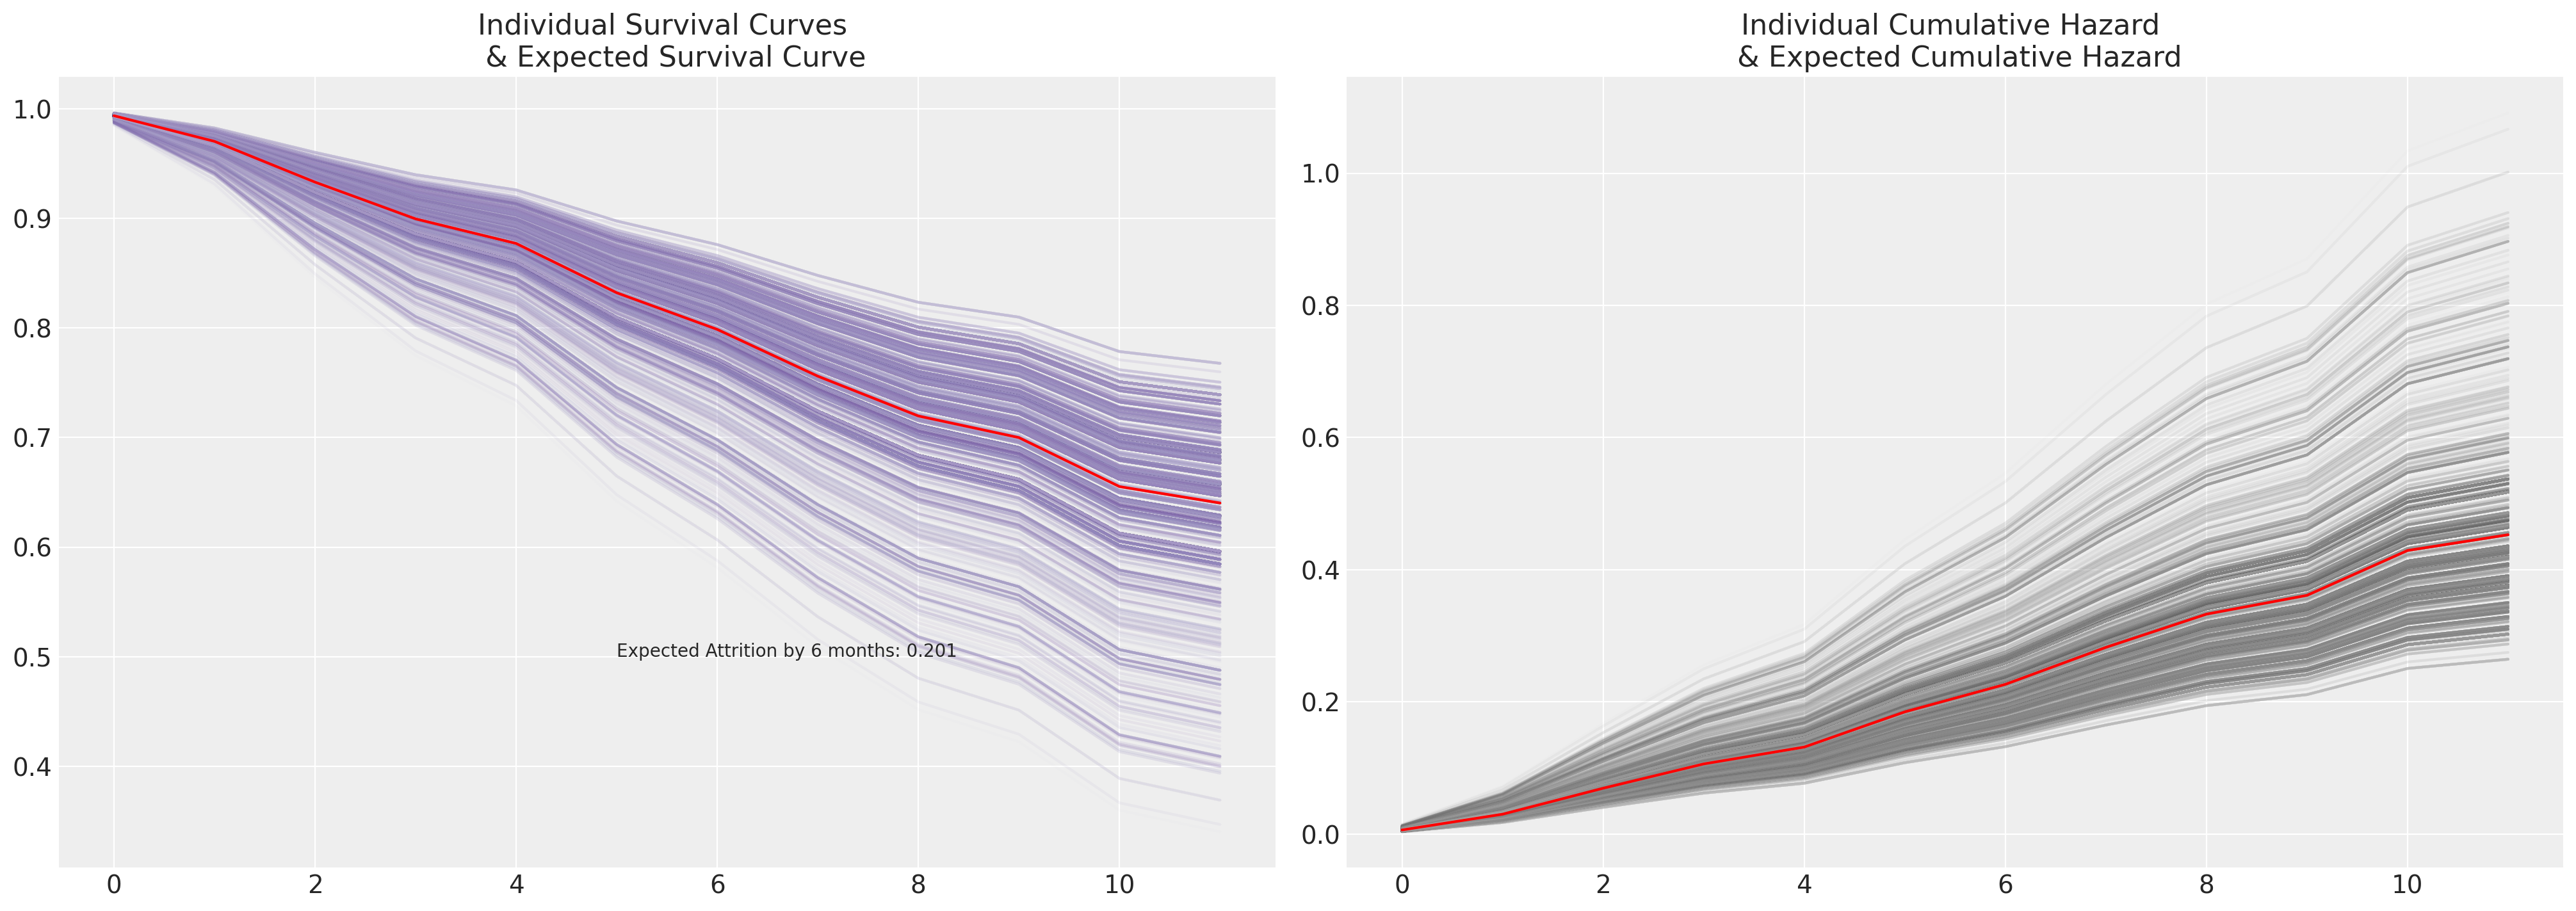

In [39]:
cm_subsection = np.linspace(0, 1, 120) 
colors_m = [cm.Purples(x) for x in cm_subsection]
colors = [cm.Greys(x) for x in cm_subsection]


fig, axs = plt.subplots(1, 2, figsize=(20, 7))
axs = axs.flatten()
cum_haz_df.plot(legend=False, color=colors, alpha=0.05, ax=axs[1])
axs[1].plot(cum_haz_df.mean(axis=1), color='red')
axs[1].set_title("Individual Cumulative Hazard \n & Expected Cumulative Hazard")

surv_df.plot(legend=False, color=colors_m, alpha=0.05, ax=axs[0])
axs[0].plot(surv_df.mean(axis=1), color='red');
axs[0].set_title("Individual Survival Curves \n  & Expected Survival Curve");
axs[0].annotate(f'Expected Attrition by 6 months: {np.round(1-surv_df.mean(axis=1).iloc[6], 3)}', (5, 0.5));

## Interrogating Frailty Models


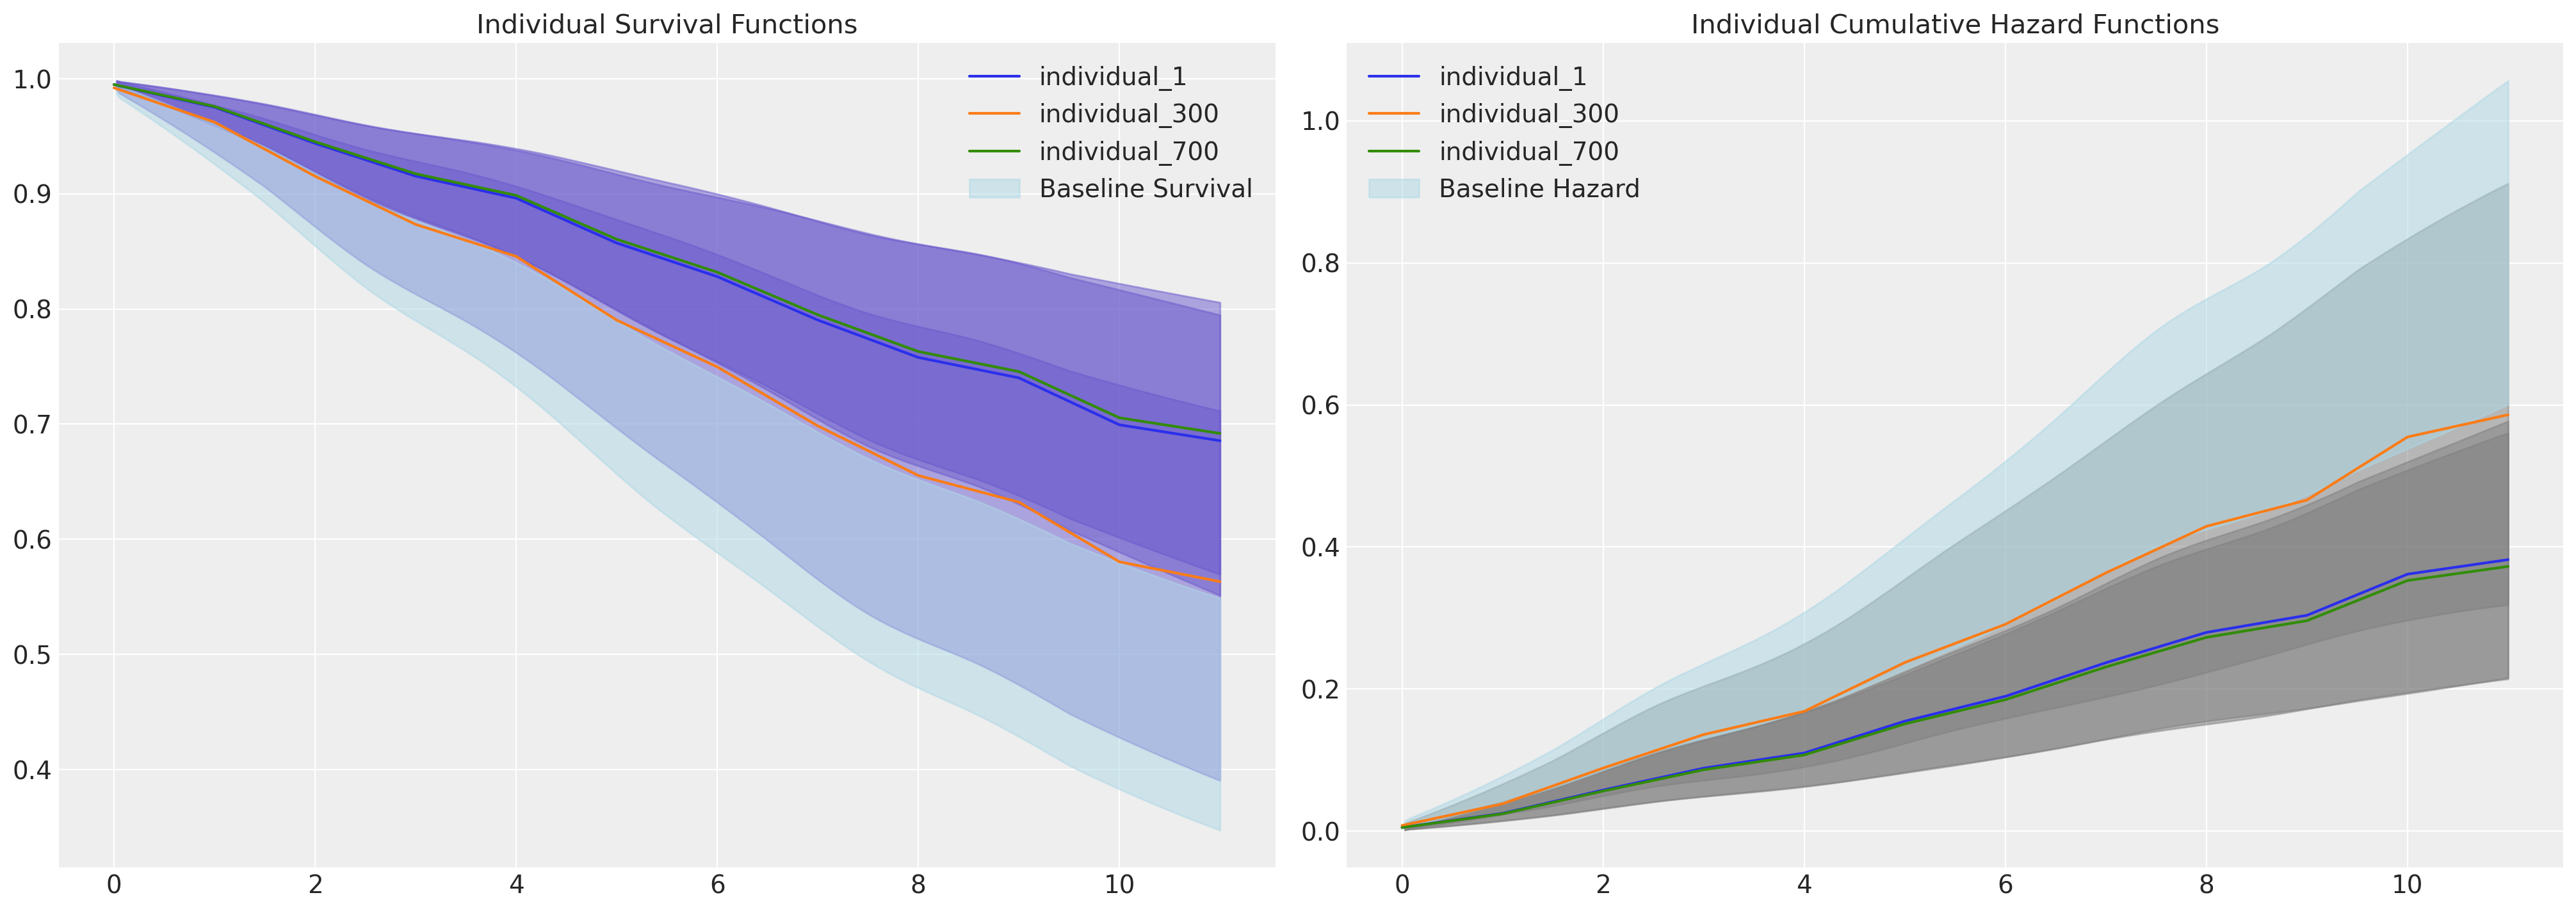

In [40]:
def extract_individual_frailty(i, retention_df):
    hazard_base = frailty_idata['posterior']['lambda0']
    beta = frailty_idata.posterior['beta']
    frailty = frailty_idata.posterior['frailty']
    full_hazard_idata = frailty.sel(frailty_id=i)*(hazard_base * np.exp( 
                                        beta.sel(preds='sentiment')*retention_df.iloc[i]['sentiment'] + 
                                        beta.sel(preds='Male')*retention_df.iloc[i]['M'] +
                                        beta.sel(preds='Low')*retention_df.iloc[i]['Low'] +  
                                        beta.sel(preds='Medium')*retention_df.iloc[i]['Medium'] 
                                        ))

    cum_haz_idata = cum_hazard(full_hazard_idata)
    survival_idata = survival(full_hazard_idata)
    return full_hazard_idata, cum_haz_idata, survival_idata, hazard_base

def plot_individual_frailty(retention_df, individuals=[1, 300, 700]): 
    fig, axs = plt.subplots(1, 2, figsize=(20, 7))
    axs = axs.flatten()
    for i in individuals:
        haz_idata, cum_haz_idata, survival_idata, base_hazard = extract_individual_frailty(i, retention_df)
        axs[0].plot(get_mean(survival_idata), label=f'individual_{i}')
        az.plot_hdi(range(12),survival_idata, ax=axs[0], fill_kwargs={'color': 'slateblue'})
        axs[1].plot(get_mean(cum_haz_idata), label=f'individual_{i}')
        az.plot_hdi(range(12),cum_haz_idata, ax=axs[1], fill_kwargs={'color': 'grey'})
        axs[0].set_title("Individual Survival Functions", fontsize=15)
        axs[1].set_title("Individual Cumulative Hazard Functions", fontsize=15)
    az.plot_hdi(range(12), survival(base_hazard), color='lightblue', ax=axs[0], fill_kwargs={"label": "Baseline Survival"})
    az.plot_hdi(range(12), cum_hazard(base_hazard), color='lightblue', ax=axs[1], fill_kwargs={"label": "Baseline Hazard"})
    axs[0].legend()
    axs[1].legend()

plot_individual_frailty(retention_df)

In [42]:
def create_predictions(retention_df):
    cum_haz = {}
    surv = {}
    for i in range(len(retention_df)):
        haz_idata, cum_haz_idata, survival_idata, base_hazard = extract_individual_frailty(i, retention_df)
        cum_haz[i] = get_mean(cum_haz_idata)
        surv[i] = get_mean(survival_idata)
    cum_haz = pd.DataFrame(cum_haz)
    surv = pd.DataFrame(surv)
    return cum_haz, surv

cum_haz_frailty_df, surv_frailty_df = create_predictions(retention_df)
cum_haz_frailty_df.head()

0         1         2         3         4         5         6     \
0  0.008502  0.005293  0.006357  0.005107  0.005449  0.007405  0.005249   
1  0.040489  0.025169  0.030234  0.024287  0.025928  0.035236  0.024965   
2  0.093247  0.057977  0.069642  0.055951  0.059720  0.081151  0.057468   
3  0.142765  0.088755  0.106604  0.085639  0.091402  0.124226  0.087941   
4  0.177089  0.110074  0.132219  0.106235  0.113406  0.154068  0.109059   

       7         8         9     ...      3760      3761      3762      3763  \
0  0.005729  0.005401  0.005756  ...  0.006222  0.004433  0.008294  0.005695   
1  0.027252  0.025733  0.027350  ...  0.029684  0.021135  0.039443  0.027077   
2  0.062737  0.059258  0.062982  ...  0.068380  0.048685  0.090821  0.062357   
3  0.096013  0.090705  0.096407  ...  0.104662  0.074520  0.139005  0.095437   
4  0.119067  0.112521  0.119589  ...  0.129801  0.092424  0.172423  0.118392   

       3764      3765      3766      3767      3768      3769  
0  0.005427  0.004277  0.006124  0.008394  0.003612  0.005121  
1  0.025835  0.020419  0.029116  0.039916  0.017176  0.024343  
2  0.059505  0.047034  0.066999  0.091870  0.039531  0.056019  
3  0.091061  0.072000  0.102539  0.140607  0.060505  0.085718  
4  0.112929  0.089296  0.127170  0.174380  0.075035  0.106320  

[5 rows x 3770 columns]

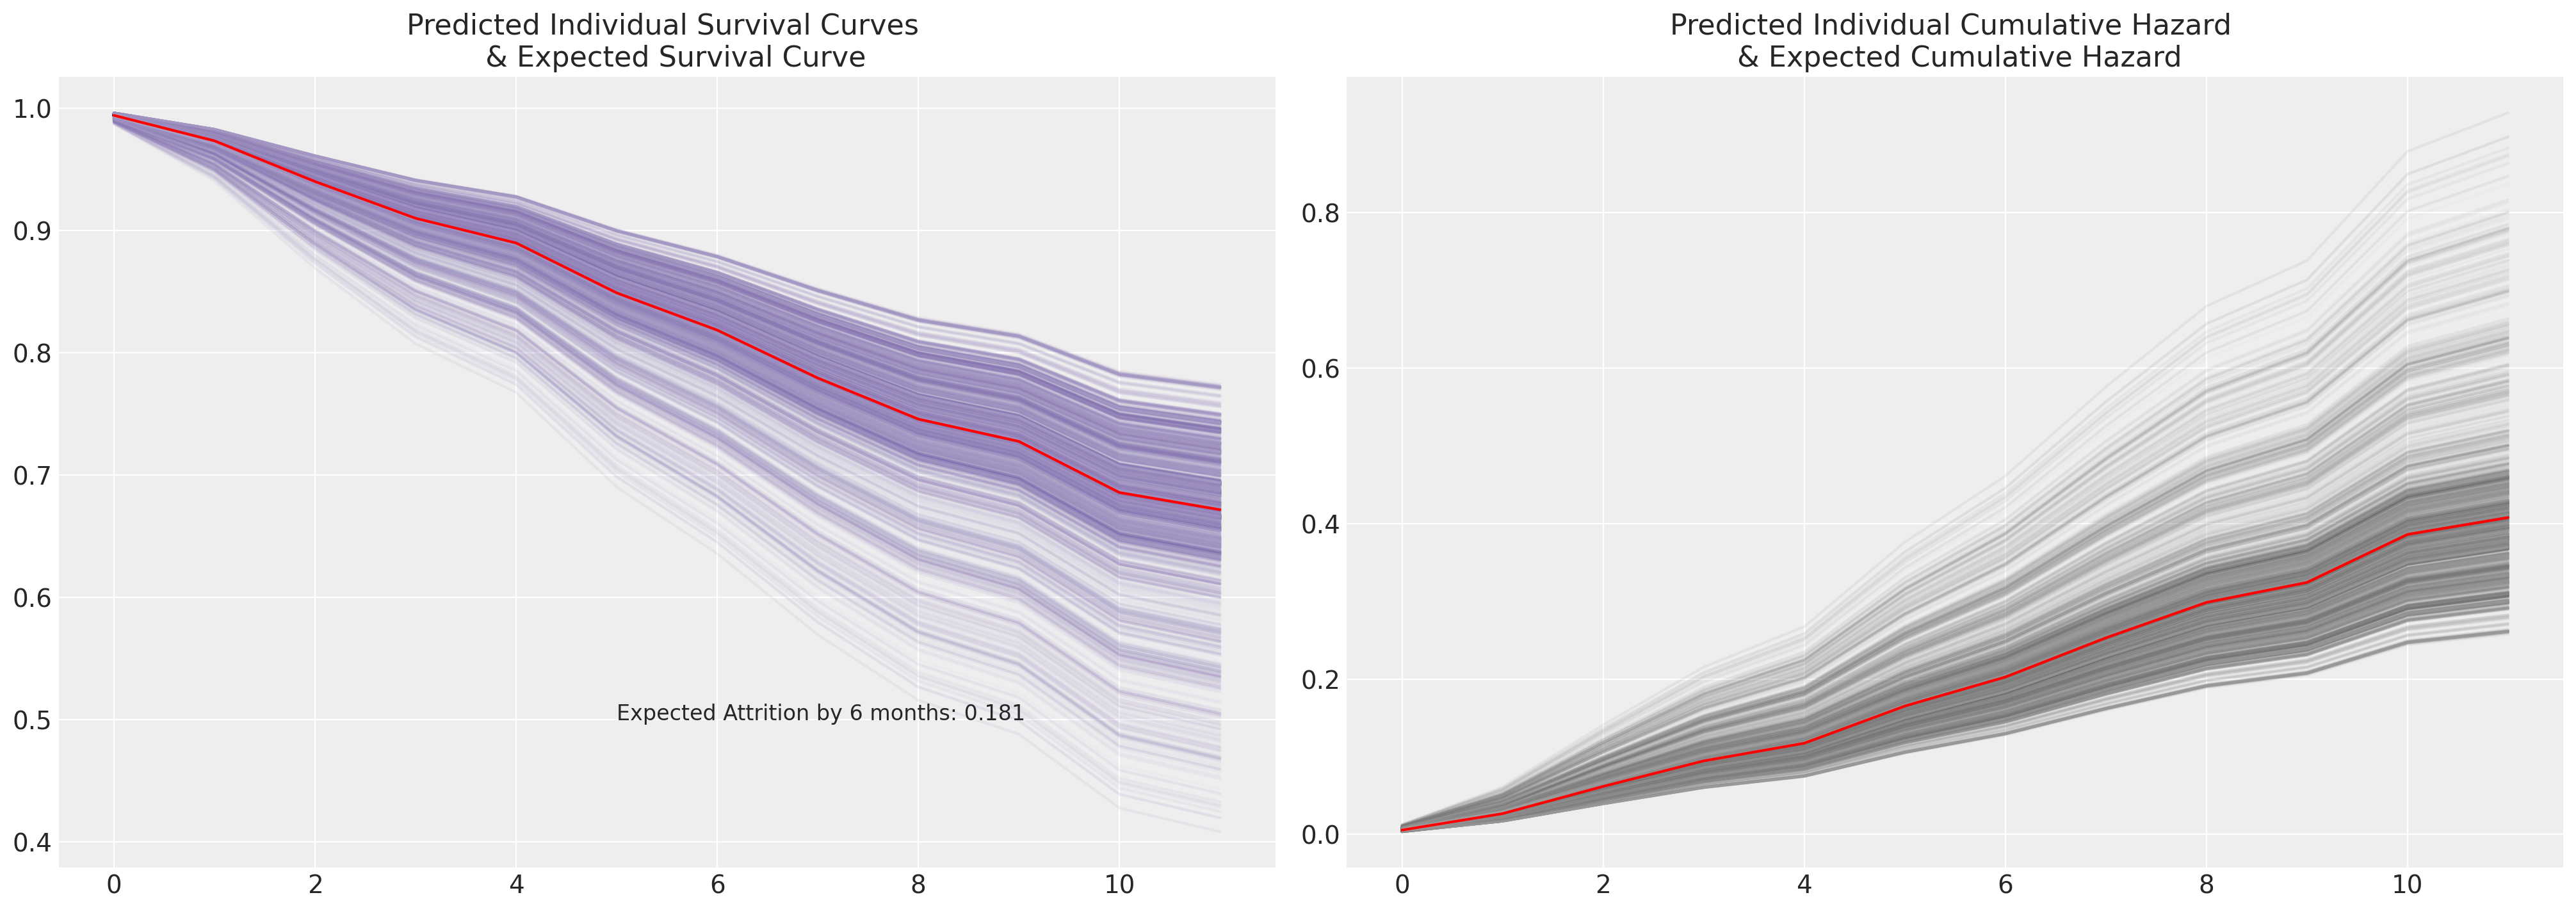

In [43]:
cm_subsection = np.linspace(0, 1, 120) 
colors_m = [cm.Purples(x) for x in cm_subsection]
colors = [cm.Greys(x) for x in cm_subsection]


fig, axs = plt.subplots(1, 2, figsize=(20, 7))
axs = axs.flatten()
cum_haz_frailty_df.plot(legend=False, color=colors, alpha=0.05, ax=axs[1])
axs[1].plot(cum_haz_frailty_df.mean(axis=1), color='red')
axs[1].set_title("Predicted Individual Cumulative Hazard \n & Expected Cumulative Hazard")

surv_frailty_df.plot(legend=False, color=colors_m, alpha=0.05, ax=axs[0])
axs[0].plot(surv_frailty_df.mean(axis=1), color='red');
axs[0].set_title("Predicted Individual Survival Curves \n  & Expected Survival Curve");
axs[0].annotate(f'Expected Attrition by 6 months: {np.round(1-surv_frailty_df.mean(axis=1).iloc[6], 3)}', (5, 0.5), fontsize=12);

In [44]:
beta_individual = frailty_idata["posterior"]["frailty"]
beta_individual = beta_individual.sel(frailty_id=range(120))
predicted = beta_individual.mean(("chain", "draw"))
predicted = predicted.sortby(predicted)
ci_lb = beta_individual.quantile(0.025, ("chain", "draw")).sortby(predicted)
ci_ub = beta_individual.quantile(0.975, ("chain", "draw")).sortby(predicted)
hdi = az.hdi(beta_individual, hdi_prob=0.5).sortby(predicted)
hdi2 = az.hdi(beta_individual, hdi_prob=0.85).sortby(predicted)

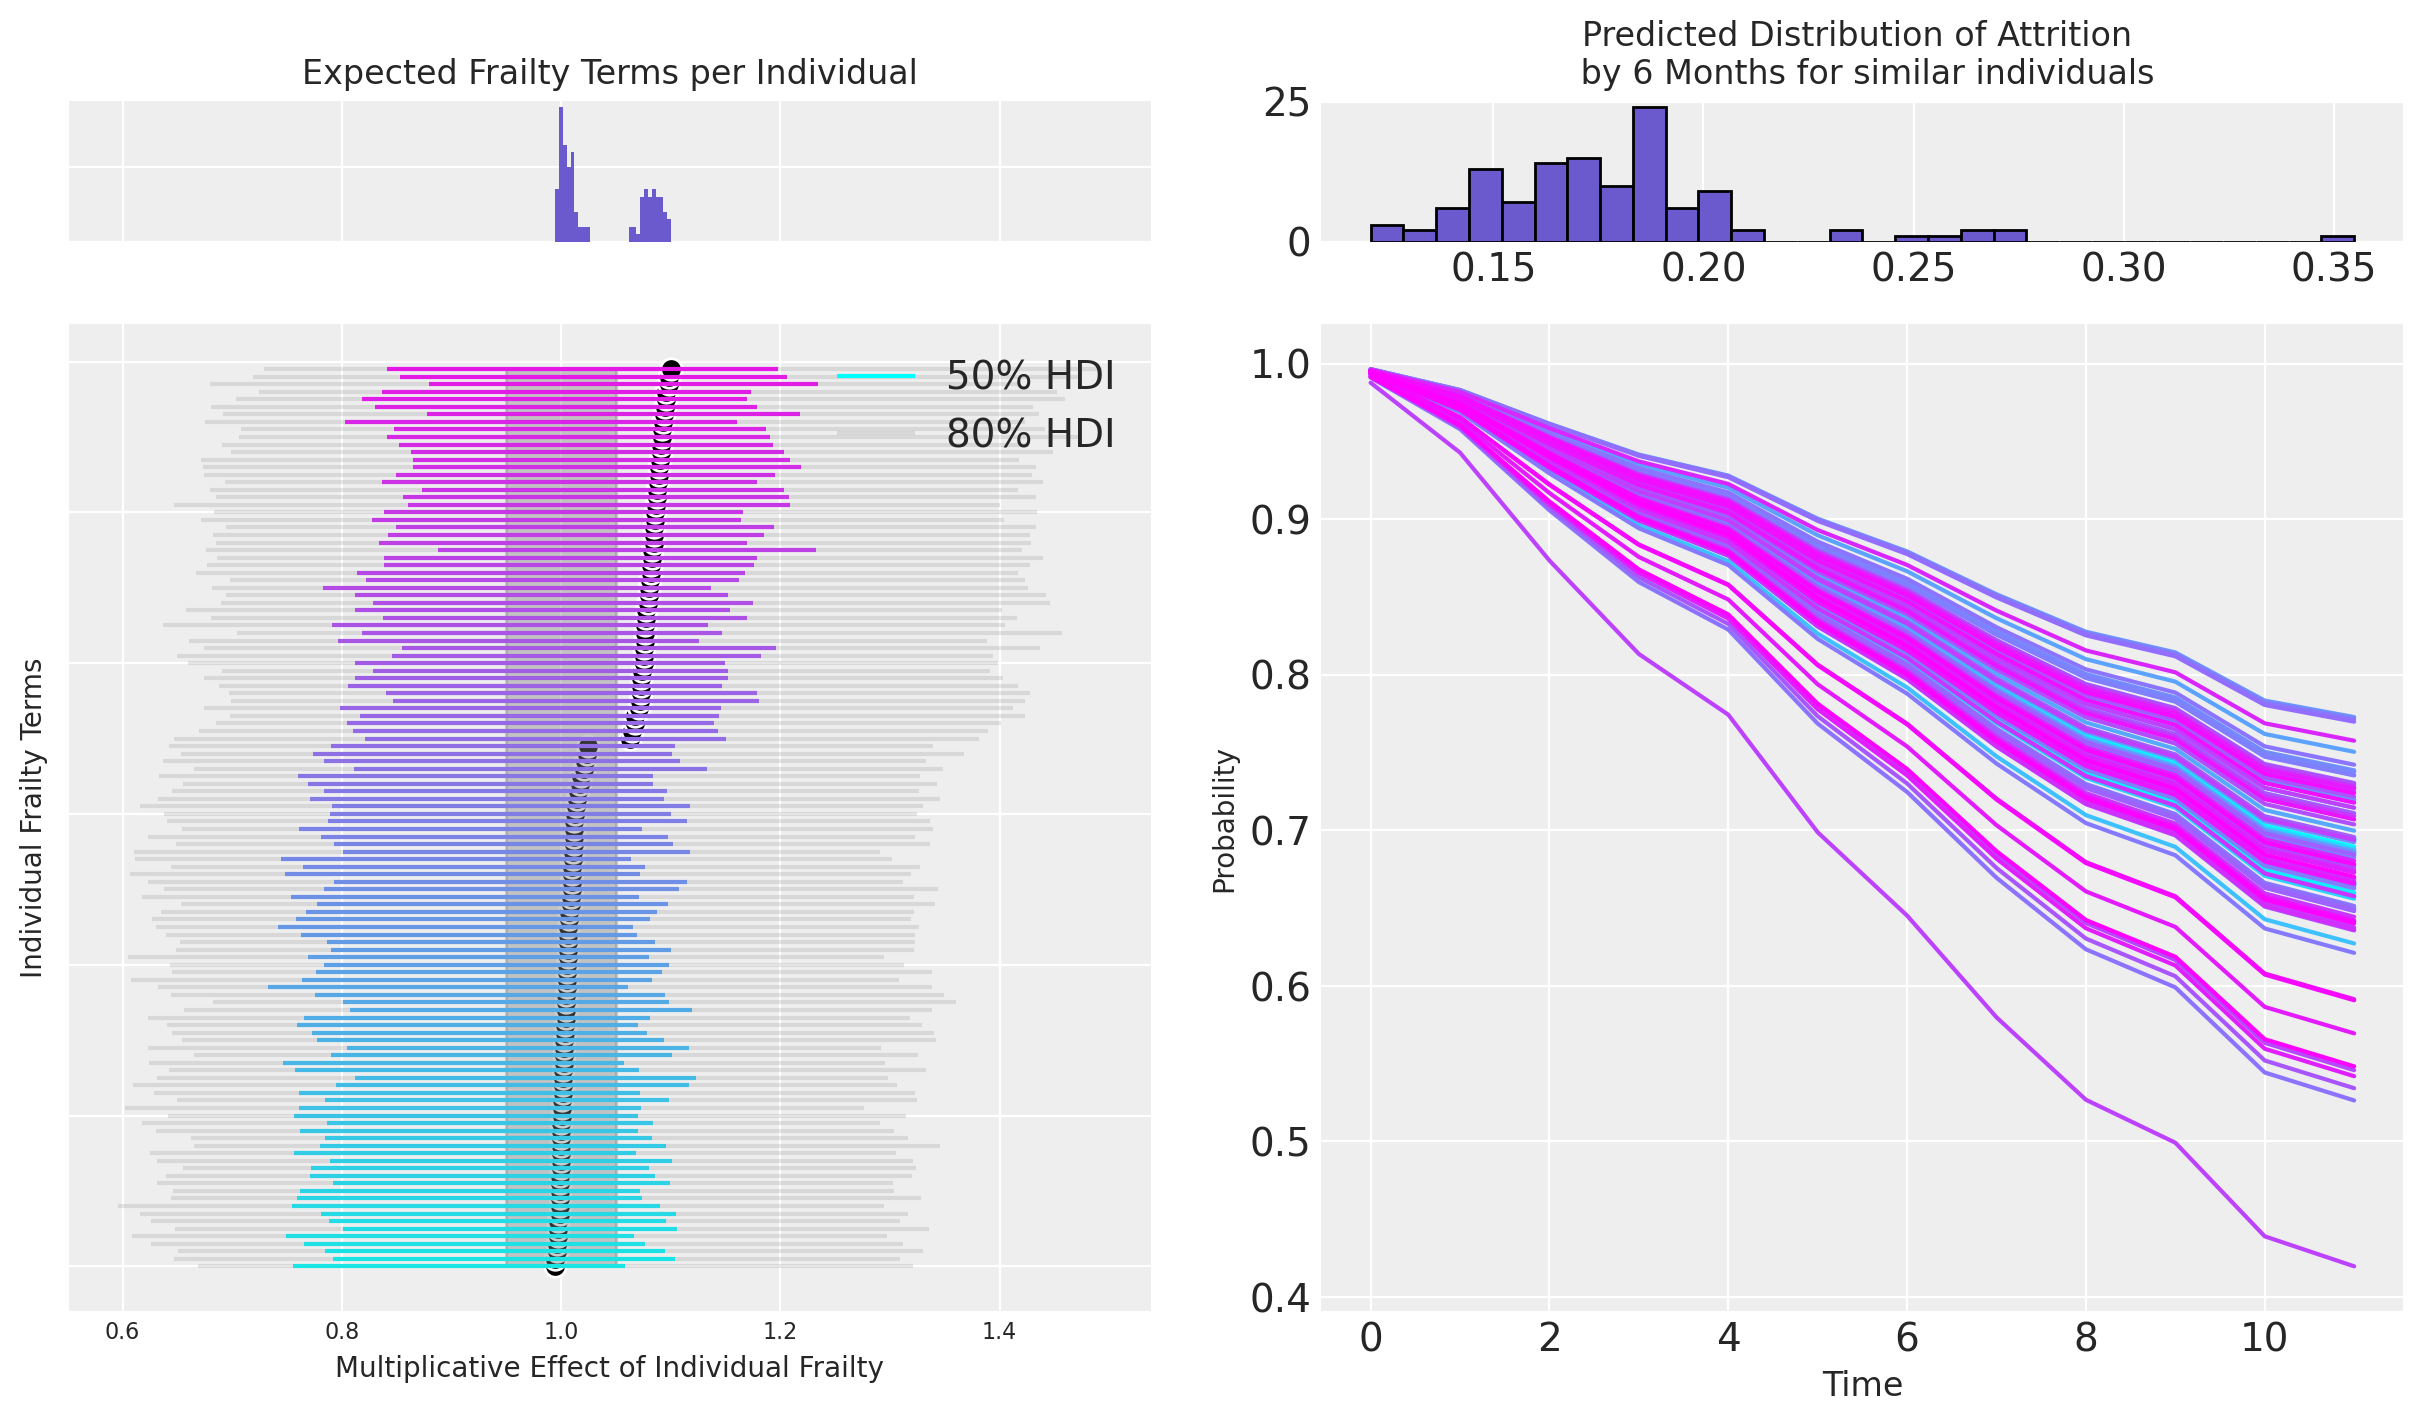

In [47]:
cm_subsection = np.linspace(0, 1, 120) 
colors = [cm.cool(x) for x in cm_subsection]

fig = plt.figure(figsize=(12, 7))
gs = fig.add_gridspec(
    2,
    2,
    height_ratios=(1, 7),
    left=0.1,
    right=0.9,
    bottom=0.1,
    top=0.9,
    wspace=0.05,
    hspace=0.05,
)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax.set_yticklabels([])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histx.set_title("Expected Frailty Terms per Individual", fontsize=12)
ax_histx.hist(predicted, bins=30, color='slateblue')
ax_histx.set_yticklabels([])
ax_histx.tick_params(labelsize=8)
ax.set_ylabel("Individual Frailty Terms", fontsize=10)
ax.tick_params(labelsize=8)
ax.hlines(
    range(len(predicted)),
    hdi.sel(hdi='lower').to_array(),
    hdi.sel(hdi='higher').to_array(),
    color=colors,
    label='50% HDI'
)
ax.hlines(
    range(len(predicted)),
    hdi2.sel(hdi='lower').to_array(),
    hdi2.sel(hdi='higher').to_array(),
    color='grey',
    alpha=0.2, 
    label='80% HDI'
)
ax.scatter(predicted, range(len(predicted)), color="black", ec="white", s=60)
ax.set_xlabel("Multiplicative Effect of Individual Frailty", fontsize=10)
ax.legend()
ax.fill_betweenx(range(len(predicted)), 0.95, 1.05, alpha=0.4, color="grey");

ax1 = fig.add_subplot(gs[1, 1])
surv_frailty_df[list(predicted['frailty_id'].values)].plot(ax=ax1, legend=False, color=colors);
ax1_hist = fig.add_subplot(gs[0, 1])
ax1_hist.hist((1 - surv_frailty_df[list(predicted['frailty_id'].values)].iloc[6]), bins=30, color='slateblue', ec='black')
ax1.set_xlabel("Time", fontsize=12)
ax1_hist.set_title("Predicted Distribution of Attrition \n by 6 Months for similar individuals", fontsize=12);
ax1.set_ylabel('Probability', fontsize=10);


## Comparing the Model Implications

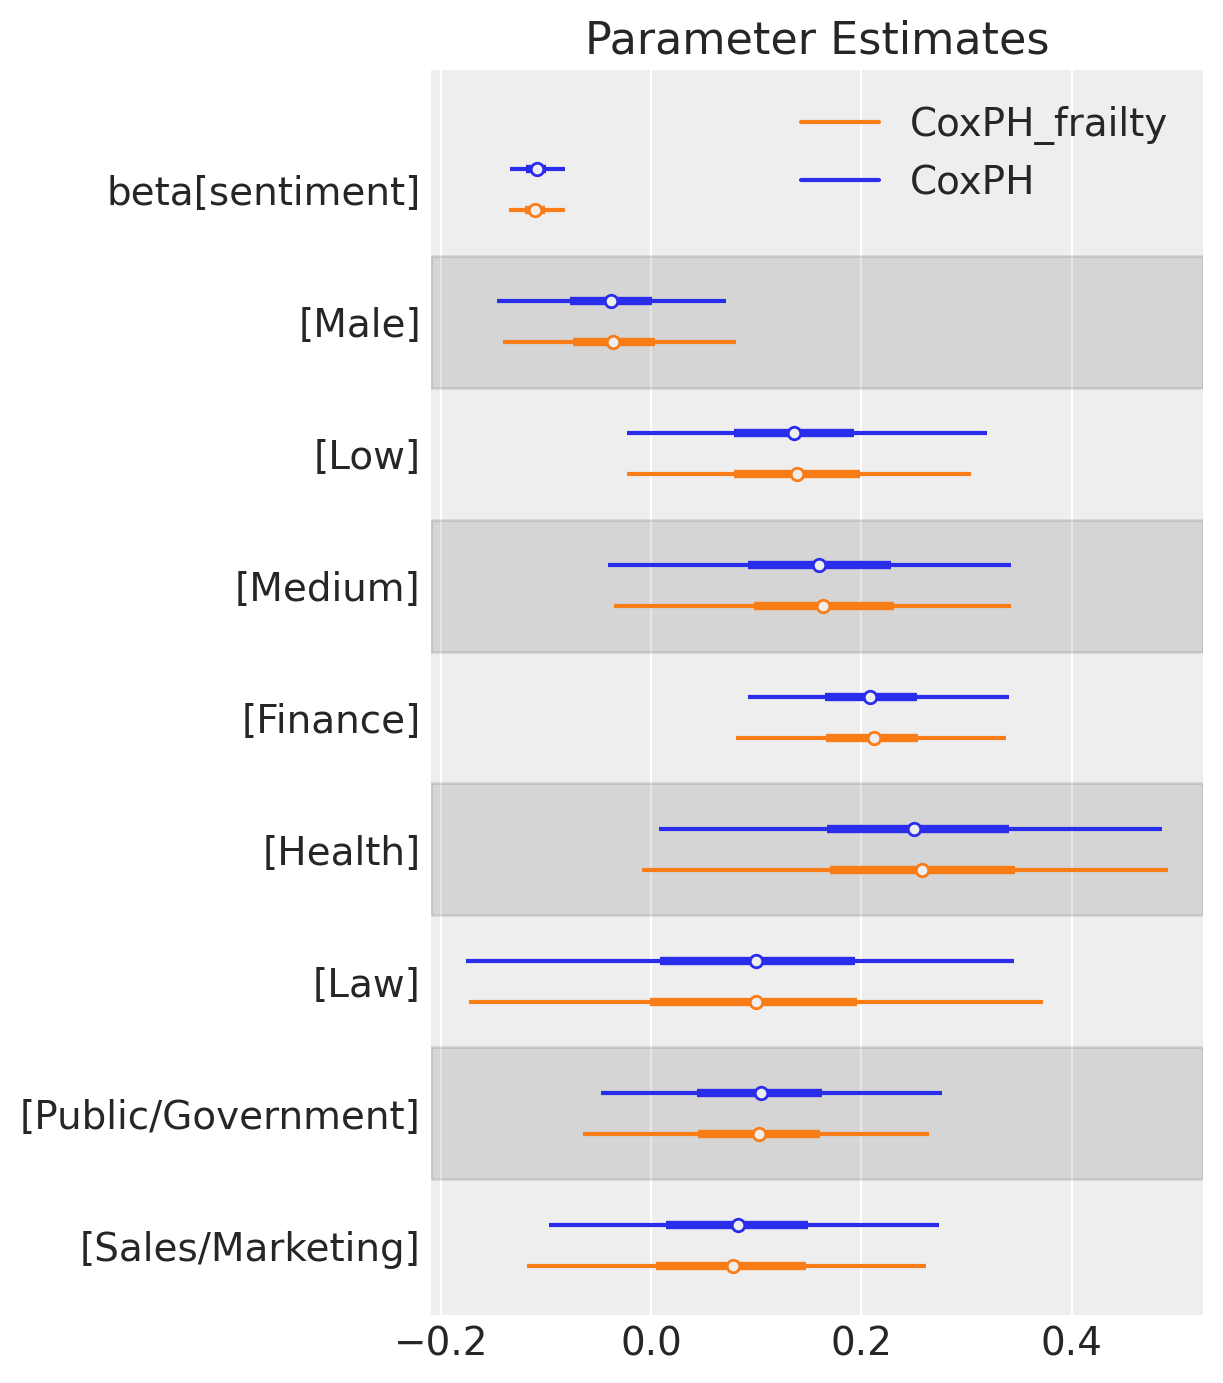

In [49]:
ax = az.plot_forest([base_idata, frailty_idata], var_names=['beta'], combined=True, model_names=['CoxPH', 'CoxPH_frailty'])
ax[0].set_title("Parameter Estimates");

0.17975611292210547
0.2012819253347755


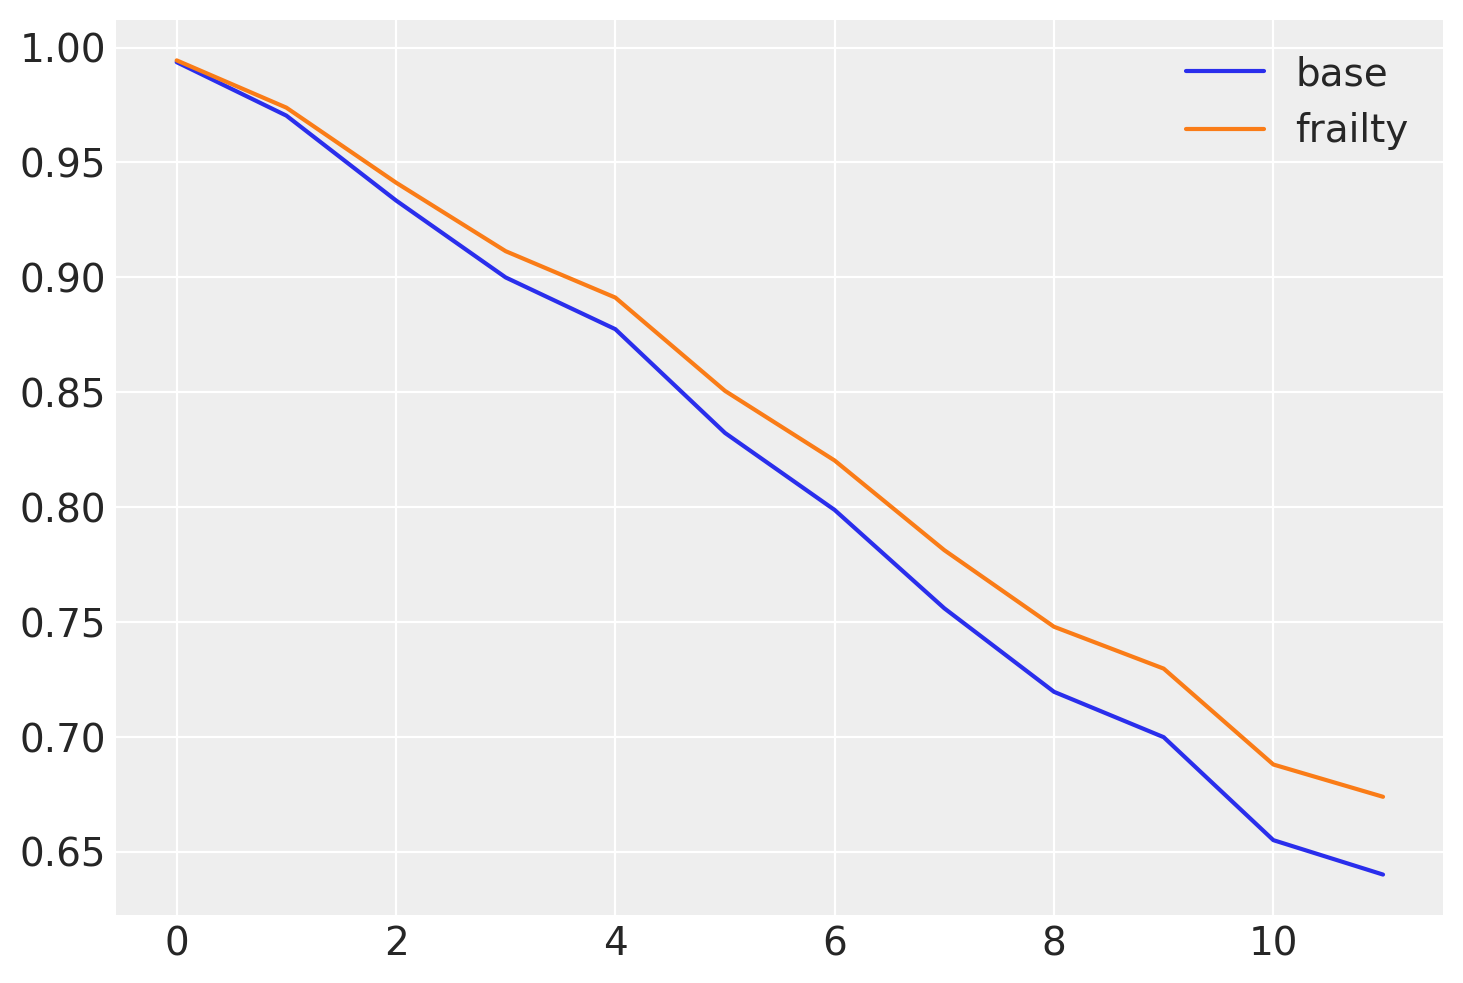

In [469]:
fig, ax = plt.subplots()
ax.plot(surv_df.mean(axis=1), label='base')
ax.plot(surv_frailty_df.mean(axis=1), label='frailty')
ax.legend()
print(1-surv_frailty_df.mean(axis=1).iloc[6])
print(1-surv_df.mean(axis=1).iloc[6])


## Authors
- Authored by [Nathaniel Forde](https://nathanielf.github.io/) in July 2023 

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [4]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Wed Jun 21 2023

Python implementation: CPython
Python version       : 3.9.16
IPython version      : 8.11.0

pytensor: 2.11.1

numpy     : 1.23.5
matplotlib: 3.7.1
pandas    : 1.5.3
pymc      : 5.3.0
arviz     : 0.15.1

Watermark: 2.3.1



:::{include} ../page_footer.md
:::